<a href="https://colab.research.google.com/github/flistz/DASC6510-Bayes/blob/main/BayesA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import invgamma, norm, stats, gamma, binom, bernoulli, multivariate_normal, wishart, gaussian_kde
import scipy.stats as stats
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from io import StringIO
from numpy.linalg import inv, cholesky
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from scipy.special import expit as logistic_function
import statsmodels.api as sm
from numpy.random import uniform
from scipy.linalg import solve
from scipy.special import expit, logit


# *Problem 1: Exercise 8.3*

## a)

In [33]:
school1 = np.array([
    2.11, 9.75, 13.88, 11.3, 8.93, 15.66, 16.38, 4.54, 8.86, 11.94,
    12.47, 11.11, 11.65, 14.53, 9.61, 7.38, 3.34, 9.06, 9.45, 5.98,
    7.44, 8.5, 1.55, 11.45, 9.73
])

school2 = np.array([
    0.29, 1.13, 6.52, 11.72, 6.54, 5.63, 14.59, 11.74, 9.12, 9.43,
    10.64, 12.28, 9.5, 0.63, 15.35, 5.31, 8.49, 3.04, 3.77, 6.22,
    2.14, 6.58, 1.11
])

school3 = np.array([
    4.33, 7.77, 4.15, 5.64, 7.69, 5.04, 10.01, 13.43, 13.63, 9.9,
    5.72, 5.16, 4.33, 12.9, 11.27, 6.05, 0.95, 6.02, 12.22, 12.85
])

school4 = np.array([
    12.46, 6.42, 5.96, 0.92, 11.43, 2.27, 1.54, 6.55, 2.3, 0.57,
    7.4, 6.63, 7.02, 2.95, 4.44, 7.78, 8.36, 13.32, 8.81, 2.06,
    14.17, 0.88, 10.36, 4.97
])

school5 = np.array([
    12.97, 13.6, 13.54, 5.49, 11.52, 8.23, 8.98, 6.42, 12.01, 15.08,
    7.16, 10.84, 8.15, 4.27, 14.21, 15.93, 8.99, 10.12, 5.65, 14.94,
    14.2, 8.43, 10.18, 17.47
])

school6 = np.array([
    2.5, 7.56, 5.79, 4.92, 3.32, 9.65, 2.58, 3.31, 5.47, 6.98,
    9.74, 0.97, 6.2, 11.16, 13.45, 7.84, 10.43, 5.85, 5.56, 6.82,
    5.23, 1.18
])

school7 = np.array([
    7.5, 11.15, 5.82, 0.39, 4.11, 4.82, 13.56, 3.11, 6.69, 7.33,
    11.87, 9.14, 0.03, 1.76, 5.03, 3.72, 7.28, 7.15, 9.07, 8.59,
    6.53, 0.27
])

school8 = np.array([
    6.41, 3.52, 7.65, 9.56, 9.49, 4.54, 14.72, 5.63, 4.24, 8.96,
    8.59, 8.69, 6.18, 4.79, 11.67, 2.8, 7.03, 4.32, 11.51, 7.32
])

In [34]:
schools = [school1, school2, school3, school4, school5, school6, school7, school8]

schools_list = [{'school': i+1, 'hours': hours} for i, hours in enumerate(schools)]
schools_raw = pd.concat([pd.DataFrame(data) for data in schools_list])
schools_raw.head()

,school,hours
0,1,2.11
1,1,9.75
2,1,13.88
3,1,11.30
4,1,8.93


MCMC: 100%|██████████| 100000/100000 [06:24<00:00, 260.25it/s]


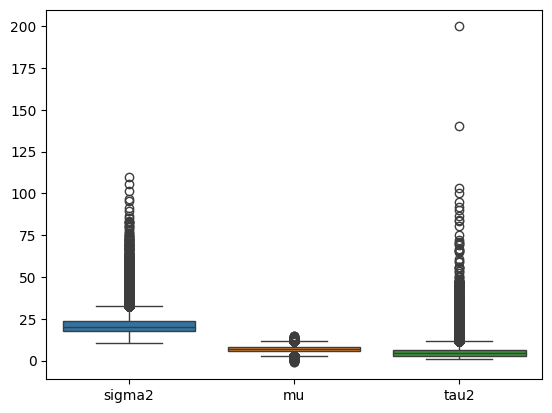

Effective Sample Size for sigma2: 3579.9125821454936
Effective Sample Size for mu: 1202.2235436291862
Effective Sample Size for tau2: 20552.681577820473


In [35]:
# Prior settings
mu0 = 7
g20 = 5
t20 = 10
eta0 = 2
s20 = 15
nu0 = 2

# Number of schools
m = schools_raw['school'].nunique()

# Starting values
ybar = schools_raw.groupby('school')['hours'].mean().values
sv = schools_raw.groupby('school')['hours'].var().values
n = schools_raw.groupby('school').size().values

theta = ybar
sigma2 = sv.mean()
mu = theta.mean()
tau2 = theta.var()

# MCMC
N = 100000
thetas = np.zeros((N, m))
sigma_mu_tau2 = np.zeros((N, 3))

for s in tqdm.tqdm(range(N), total=N, desc="MCMC"):
    # Sample thetas
    for j in range(m):
        vtheta = 1 / (n[j] / sigma2 + 1 / tau2)
        etheta = vtheta * (ybar[j] * n[j] / sigma2 + mu / tau2)
        theta[j] = np.random.normal(etheta, np.sqrt(vtheta))

    # Sample sigma2
    nun = nu0 + n.sum()
    ss = nu0 * s20 + sum([np.sum((schools_raw[schools_raw['school'] == j+1]['hours'].values - theta[j])**2) for j in range(m)])
    sigma2 = 1 / np.random.gamma(nun / 2, 2 / ss)

    # Sample mu
    vmu = 1 / (m / tau2 + 1 / g20)
    emu = vmu * (m * theta.mean() / tau2 + mu0 / g20)
    mu = np.random.normal(emu, np.sqrt(vmu))

    # Sample tau2
    etam = eta0 + m
    ss = eta0 * t20 + sum((theta - mu)**2)
    tau2 = 1 / np.random.gamma(etam / 2, 2 / ss)

    # Store params
    thetas[s, :] = theta
    sigma_mu_tau2[s, :] = [sigma2, mu, tau2]

# Assess convergence with diagnostic plots
sns.boxplot(data=pd.DataFrame(sigma_mu_tau2, columns=['sigma2', 'mu', 'tau2']))
plt.show()

# Evaluate effective sample size
print("Effective Sample Size for sigma2:", az.ess(sigma_mu_tau2[:, 0]))
print("Effective Sample Size for mu:", az.ess(sigma_mu_tau2[:, 1]))
print("Effective Sample Size for tau2:", az.ess(sigma_mu_tau2[:, 2]))

In [36]:
theta, sigma2, mu, tau2

(array([5.5129779 , 4.52822562, 6.41854305, 6.13210504, 6.59158499,
        4.42436888, 7.4853816 , 5.45129727]),
 22.885936503457394,
 5.5921954593756205,
 4.001064884937969)

## b)

Posterior means:
 [21.61405779  7.15630934  5.41478612]
Posterior 95% credible intervals:
           sigma2         mu       tau2
2.5%   14.542934   3.932093   1.611812
50%    20.324207   7.168892   4.298488
97.5%  36.402654  10.364623  15.944977


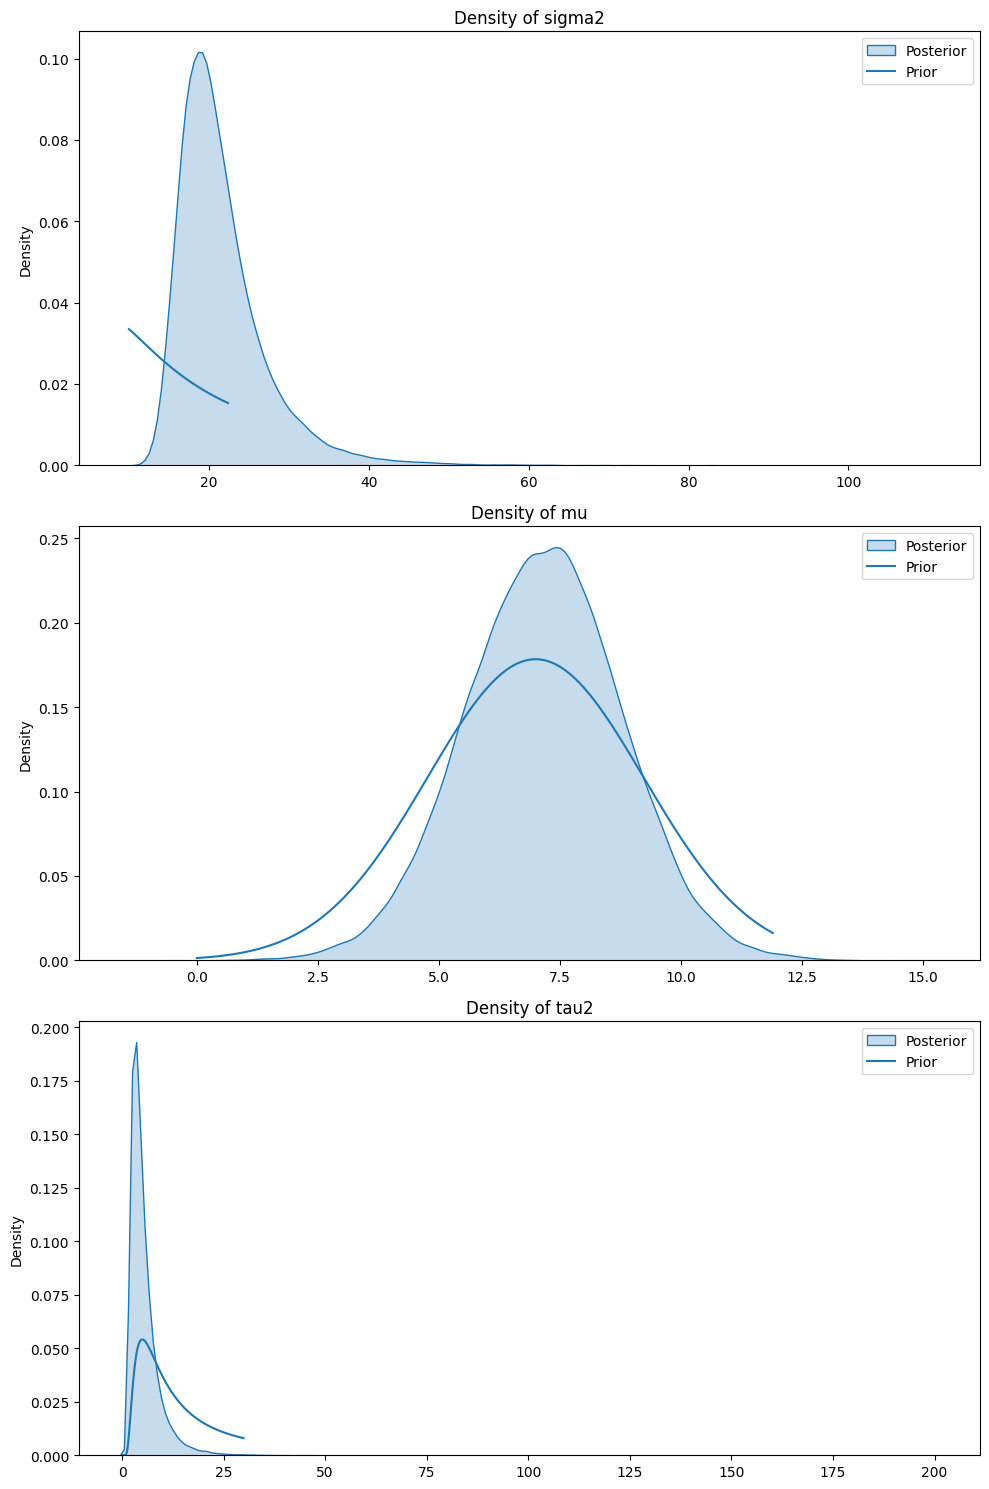

In [41]:
posterior_quantiles = np.percentile(sigma_mu_tau2, [2.5, 50, 97.5], axis=0)
posterior_means = np.mean(sigma_mu_tau2, axis=0)

# Display the results
quantile_indices = ['2.5%', '50%', '97.5%']
posterior_summary = pd.DataFrame(posterior_quantiles, index=quantile_indices, columns=['sigma2', 'mu', 'tau2'])
print("Posterior means:\n", posterior_means)
print("Posterior 95% credible intervals:\n", posterior_summary)

# Compute the prior densities using the parameters provided
sigma2_prior_values = np.arange(10, 22.5, 0.1)
sigma2_prior_density = invgamma.pdf(sigma2_prior_values, nu0 / 2, scale=nu0 * s20 / 2)

tau2_prior_values = np.arange(0, 30, 0.1)
tau2_prior_density = invgamma.pdf(tau2_prior_values, eta0 / 2, scale=eta0 * t20 / 2)

mu_prior_values = np.arange(0, 12, 0.1)
mu_prior_density = norm.pdf(mu_prior_values, mu0, np.sqrt(g20))

# Plot the prior densities and posterior densities
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.kdeplot(sigma_mu_tau2[:, 0], ax=axes[0], fill=True, label="Posterior")
axes[0].plot(sigma2_prior_values, sigma2_prior_density, label="Prior")
axes[0].set_title('Density of sigma2')
axes[0].legend()

sns.kdeplot(sigma_mu_tau2[:, 1], ax=axes[1], fill=True, label="Posterior")
axes[1].plot(mu_prior_values, mu_prior_density, label="Prior")
axes[1].set_title('Density of mu')
axes[1].legend()

sns.kdeplot(sigma_mu_tau2[:, 2], ax=axes[2], fill=True, label="Posterior")
axes[2].plot(tau2_prior_values, tau2_prior_density, label="Prior")
axes[2].set_title('Density of tau2')
axes[2].legend()

plt.tight_layout()
plt.show()


## c)

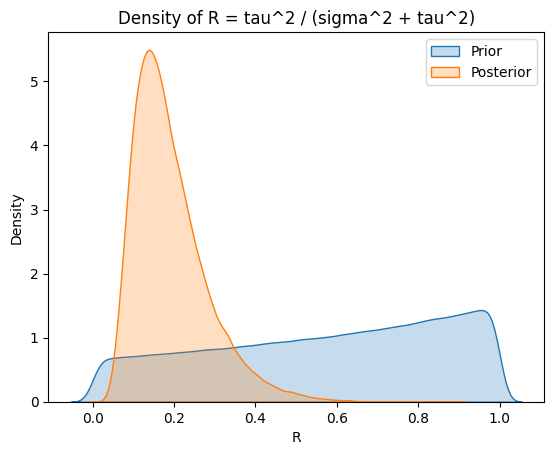

Mean of the posterior distribution of R: 0.19099733293750584


In [42]:
# Prior parameters
eta0 = 2
t20 = 10
nu0 = 2
s20 = 15

# Simulate prior samples for tau^2 and sigma^2
t20_prior = 1 / np.random.gamma(eta0 / 2, scale=(eta0 * t20 / 2), size=int(1e6))
s20_prior = 1 / np.random.gamma(nu0 / 2, scale=(nu0 * s20 / 2), size=int(1e6))

# Calculate R for prior
R_prior_values = t20_prior / (t20_prior + s20_prior)

# Assuming SMT is the array with the MCMC samples where the columns correspond to ['sigma2', 'mu', 'tau2']
# Replace 'SMT' with the actual variable from your MCMC samples
R_post_values = sigma_mu_tau2[:, 2] / (sigma_mu_tau2[:, 2] + sigma_mu_tau2[:, 0])

# Plotting the prior and posterior densities of R
sns.kdeplot(R_prior_values, fill=True, label='Prior')
sns.kdeplot(R_post_values, fill=True, label='Posterior')
plt.title('Density of R = tau^2 / (sigma^2 + tau^2)')
plt.xlabel('R')
plt.ylabel('Density')
plt.legend()
plt.show()

# Computing and printing the mean of the posterior of R
mean_R_post = np.mean(R_post_values)
print("Mean of the posterior distribution of R:", mean_R_post)


## d)

In [43]:
# Calculate the posterior probability that theta_7 is smaller than theta_6
theta7_lt_theta6 = thetas[:, 6] < thetas[:, 5]
posterior_prob_theta7_lt_theta6 = np.mean(theta7_lt_theta6)
print(f"Posterior probability that theta_7 is smaller than theta_6: {posterior_prob_theta7_lt_theta6}")

# Calculate the posterior probability that theta_7 is the smallest of all thetas
theta7_smallest = np.all(thetas[:, 6, None] < np.delete(thetas, 6, axis=1), axis=1)
posterior_prob_theta7_smallest = np.mean(theta7_smallest)
print(f"Posterior probability that theta_7 is the smallest: {posterior_prob_theta7_smallest}")

Posterior probability that theta_7 is smaller than theta_6: 0.50703
Posterior probability that theta_7 is the smallest: 0.13027


## e)

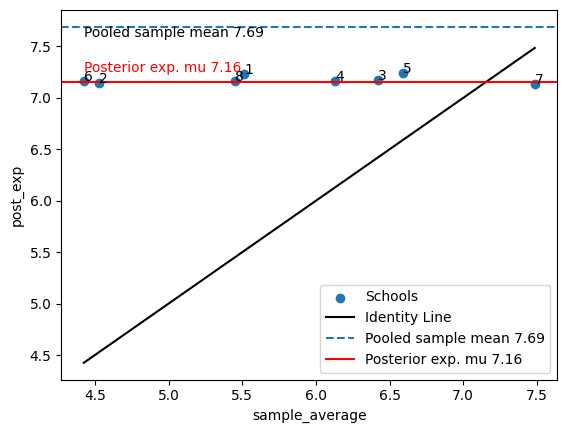

In [54]:
# Compute sample averages and posterior expectations
sample_average = ybar
post_exp_theta = thetas.mean(axis=0)

# Compute the sample mean of all observations and the posterior mean of mu
pooled_sample_mean = schools_raw['hours'].mean()
posterior_mean_mu = sigma_mu_tau2[:, 1].mean()

# Create a scatter plot
plt.scatter(sample_average, post_exp_theta, label='Schools')

# Label each point with the school number
for i, (x, y) in enumerate(zip(sample_average, post_exp_theta), 1):
    plt.text(x, y, str(i))

# Add a line with slope 1 and intercept 0
plt.plot([min(sample_average), max(sample_average)],
         [min(sample_average), max(sample_average)], 'k-', label='Identity Line')

# Add horizontal lines for pooled sample mean and posterior expectation of mu
plt.axhline(y=pooled_sample_mean, linestyle='--', label=f'Pooled sample mean {pooled_sample_mean:.2f}')
plt.axhline(y=posterior_mean_mu, color='red', label=f'Posterior exp. mu {posterior_mean_mu:.2f}')

# Annotations
plt.text(min(sample_average), pooled_sample_mean - 0.1,
         f'Pooled sample mean {pooled_sample_mean:.2f}', horizontalalignment='left')
plt.text(min(sample_average), posterior_mean_mu + 0.1,
         f'Posterior exp. mu {posterior_mean_mu:.2f}', color='red', horizontalalignment='left')

# Labels and legend
plt.xlabel('sample_average')
plt.ylabel('post_exp')
plt.legend()
plt.show()

# Problem 2: Exercise 9.3

## a)

In [68]:
data_str = """
-0.85  0.27  1.38 -1.49 -1.35 -1.30 -0.70 -0.48 -0.49  1.15 -0.08 -0.12 -2.15  1.40  1.60 -0.32
 2.75 -0.20 -0.71  1.37  2.15  2.17  0.39  0.37  3.16 -0.21  0.36  0.59  1.53 -0.68 -1.38  0.47
-0.58 -1.40 -0.71  0.39  1.11  1.24 -0.35 -0.65 -0.31 -0.56 -0.64 -0.59  1.70 -1.70 -0.57 -0.79
 0.15 -0.92  1.38  0.48 -0.10 -0.04 -1.04 -0.03 -0.86  0.37  0.08  0.48  0.98 -0.65 -0.22 -0.83
 1.68 -0.60  1.38  0.30  1.01  1.03 -0.47 -0.48  0.35  0.76 -0.91  0.12 -0.55  0.30 -0.31 -0.28
-0.13  1.47  1.38 -1.40 -0.67 -0.65 -0.20 -0.95  0.06  1.80 -0.80 -0.71 -1.08  1.13  1.08  0.40
-0.15 -0.36 -0.71  0.21 -0.34 -0.33  0.84 -0.37  0.27 -0.41 -0.69 -0.35  0.57 -0.55 -0.70  1.09
-1.02 -0.84 -0.71  0.66 -0.61 -0.72  1.55 -0.37 -0.23 -0.89 -1.02 -1.06 -0.19  0.30 -0.08  1.37
-0.62 -0.28 -0.71  1.02 -0.77 -0.69  0.84  0.10 -0.38 -0.54 -1.02 -0.83  0.04 -0.10  0.27 -0.72
 0.11  0.27  1.38 -1.58 -0.13 -0.12 -1.59 -0.92 -0.10  2.14  1.14  1.54 -1.02  1.33  0.22 -0.07
-0.95  0.35 -0.71  0.39 -0.64 -0.62 -0.60 -0.20 -0.70 -0.93  1.03  0.12 -0.40 -0.70  1.28 -1.06
 0.06 -0.28  1.38 -0.15  1.28  1.24 -0.60 -0.17 -0.15  0.67 -0.36  0.00  1.09 -0.73  3.20 -1.19
-1.21  1.47  1.38 -1.49 -1.28 -1.30 -1.22 -0.71 -0.38  3.13  0.08  0.00 -2.46  2.06  1.87  1.48
 0.80 -0.52 -0.71 -0.86  0.07  0.10  0.07 -1.02  0.17 -0.09 -0.69 -0.23 -0.13  0.83 -0.72 -0.20
-0.99 -0.68 -0.71  0.93 -0.74 -0.83  1.97  0.03 -0.59 -0.73 -1.41 -1.54 -0.41  0.05  0.97 -0.66
 2.81 -0.60 -0.71  1.37  2.52  2.24  1.73  2.99 -0.88 -0.23  0.36  0.83  1.54 -1.05 -0.24 -0.63
-1.46 -0.28 -0.71  0.30 -0.54 -0.33 -0.52 -0.61 -0.80 -0.94 -0.86 -1.42  0.40 -1.38 -0.48  0.27
-0.54  2.18  1.38 -1.49 -0.91 -0.94 -0.99 -0.34  0.25  1.49 -1.30 -0.94 -1.34  1.08  1.24  0.24
 0.43  0.67  1.38 -0.15 -0.74 -0.58 -0.03 -0.37 -0.36 -0.06 -1.08 -1.18 -0.66  0.98  0.11 -0.15
-0.88 -0.44 -0.71 -0.15 -1.14 -1.19  0.94  1.39 -0.78 -0.59  0.20 -0.83 -1.04  0.78  0.30 -1.40
-0.20  0.83  1.38 -1.58 -0.81 -0.94 -1.14 -1.02 -0.02  0.62 -0.53  0.12 -1.35  1.43  0.00  0.10
 0.64  0.51  1.38 -0.15 -0.10 -0.22 -0.03 -0.07  1.56  0.24 -0.41 -0.35 -0.39  0.85 -0.36  0.38
-0.06  0.75 -0.71  1.46 -0.44 -0.51  0.99  0.51 -0.73 -0.80 -0.64 -1.66  0.67 -1.25 -0.97  0.48
-1.16  0.03  1.38 -1.58 -1.31 -1.40 -2.01 -0.51 -0.46 -0.51  2.19  2.25 -0.71  1.38  0.40  0.85
-0.29  0.99  1.38 -1.31 -0.91 -0.87 -1.27 -1.12 -0.10  1.94  0.70  0.83 -1.36  1.68  1.65 -0.06
 1.89  0.35 -0.71  0.66  0.61  0.53  0.54  0.98 -0.62  0.01  0.03  0.24  0.33  0.00 -0.77 -0.18
 0.85  0.19 -0.71  1.37  0.81  0.74  0.74  0.07 -0.49 -0.69 -0.25 -1.66  0.55 -0.50 -0.25 -0.75
-0.52  0.11 -0.71  1.11 -0.47 -0.44  1.75  1.56 -0.78 -0.84  0.25 -1.18  0.01 -0.50 -0.11 -0.99
 1.99 -1.16 -0.71 -0.06  1.21  1.28  0.47 -0.58  1.69  0.05 -1.02  0.12  1.36 -0.60 -1.36  2.12
-0.28  1.07  1.38 -1.67 -0.94 -0.97 -0.77  0.10 -0.17 -0.28 -0.19  1.07 -1.25  1.75  0.97 -0.55
-0.40 -0.68 -0.71  0.93  1.45  1.71 -0.62 -1.66  0.38 -0.75 -0.97  0.00  1.05 -1.48 -1.23 -0.24
 0.83 -1.08 -0.71  0.21  0.94  0.89  0.14  0.07  1.09 -0.07  1.92  2.84  1.04 -0.70 -0.54 -0.03
-0.42 -1.00 -0.71  0.21 -0.37 -0.47  1.01  0.03 -0.07 -0.87  0.36 -0.12  0.33  0.03 -1.07  1.55
 0.16 -0.60 -0.71  0.93 -0.24 -0.26  0.32  1.87 -0.78 -0.63  2.58  0.95  0.15 -0.45 -0.24 -1.27
 0.80  1.07 -0.71  0.57 -0.10 -0.15  0.24  1.19 -0.70 -0.22  0.42 -0.71  0.12  0.53 -0.39 -0.11
 0.36 -1.56 -0.71  0.12  2.73  2.75 -0.99 -1.53  3.45 -0.12 -0.19  0.24  1.16 -1.00 -1.04  1.43
-1.38  0.11 -0.71 -1.13 -1.01 -0.94 -0.65  2.10 -0.80 -0.79  2.19  0.71 -0.75  0.15 -0.22 -0.68
-0.39 -1.08 -0.71  0.30  0.17  0.03  0.61 -0.65  1.59 -0.19  0.53  1.07  0.95 -0.78 -0.19  0.61
 0.05 -1.00 -0.71  1.11  0.40  0.60 -0.47  0.24 -0.49 -0.78  0.36  0.12  0.66 -0.70 -0.28 -0.69
-0.65 -1.24 -0.71 -0.33  0.40  0.24 -0.87 -1.19  2.01 -0.24  1.58  1.90  0.48 -0.90 -1.16  1.52
 0.95  0.91 -0.71 -0.50  0.81  0.64 -0.75 -0.65 -0.73 -0.75 -0.47  0.48  0.35 -1.03 -1.77  2.46
-0.19  3.06  1.38 -1.67 -0.91 -0.87  1.90 -0.31 -0.33  2.41 -1.08 -0.71 -1.49  1.50 -0.08  0.72
-0.94  0.19 -0.71  0.30 -0.98 -0.94 -0.95 -0.51 -0.86 -0.96  0.64  0.36 -0.38 -0.60  1.84 -2.03
-0.21  1.86  1.38 -0.59 -0.34 -0.37 -0.97  0.44  0.09  1.04 -1.25 -0.83 -0.30  0.75  0.34  0.76
 0.32 -0.20 -0.71  1.37  0.34  0.56  0.32  0.98 -0.20 -0.63  0.86  0.36  1.00 -0.80 -0.84  0.48
-1.03 -1.00 -0.71 -0.15  0.71  0.60  0.94  0.20  0.09 -0.75 -0.97 -1.06  0.70 -0.58 -0.02 -1.40
-0.15 -0.68 -0.71  1.37  0.17  0.39  1.53  2.24 -0.88 -0.77  0.97  0.71  0.65 -0.85  0.25 -1.48
"""

df_crime = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None)
columns = ["y", "M", "So", "Ed", "Po1", "Po2", "LF", "M.F", "Pop", "NW", "U1", "U2", "GDP", "Ineq", "Prob", "Time"]
df_crime.columns = columns
df_crime.head()

,y,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,GDP,Ineq,Prob,Time
0,-0.85,0.27,1.38,-1.49,-1.35,-1.30,-0.70,-0.48,-0.49,1.15,-0.08,-0.12,-2.15,1.40,1.60,-0.32
1,2.75,-0.20,-0.71,1.37,2.15,2.17,0.39,0.37,3.16,-0.21,0.36,0.59,1.53,-0.68,-1.38,0.47
2,-0.58,-1.40,-0.71,0.39,1.11,1.24,-0.35,-0.65,-0.31,-0.56,-0.64,-0.59,1.70,-1.70,-0.57,-0.79
3,0.15,-0.92,1.38,0.48,-0.10,-0.04,-1.04,-0.03,-0.86,0.37,0.08,0.48,0.98,-0.65,-0.22,-0.83
4,1.68,-0.60,1.38,0.30,1.01,1.03,-0.47,-0.48,0.35,0.76,-0.91,0.12,-0.55,0.30,-0.31,-0.28


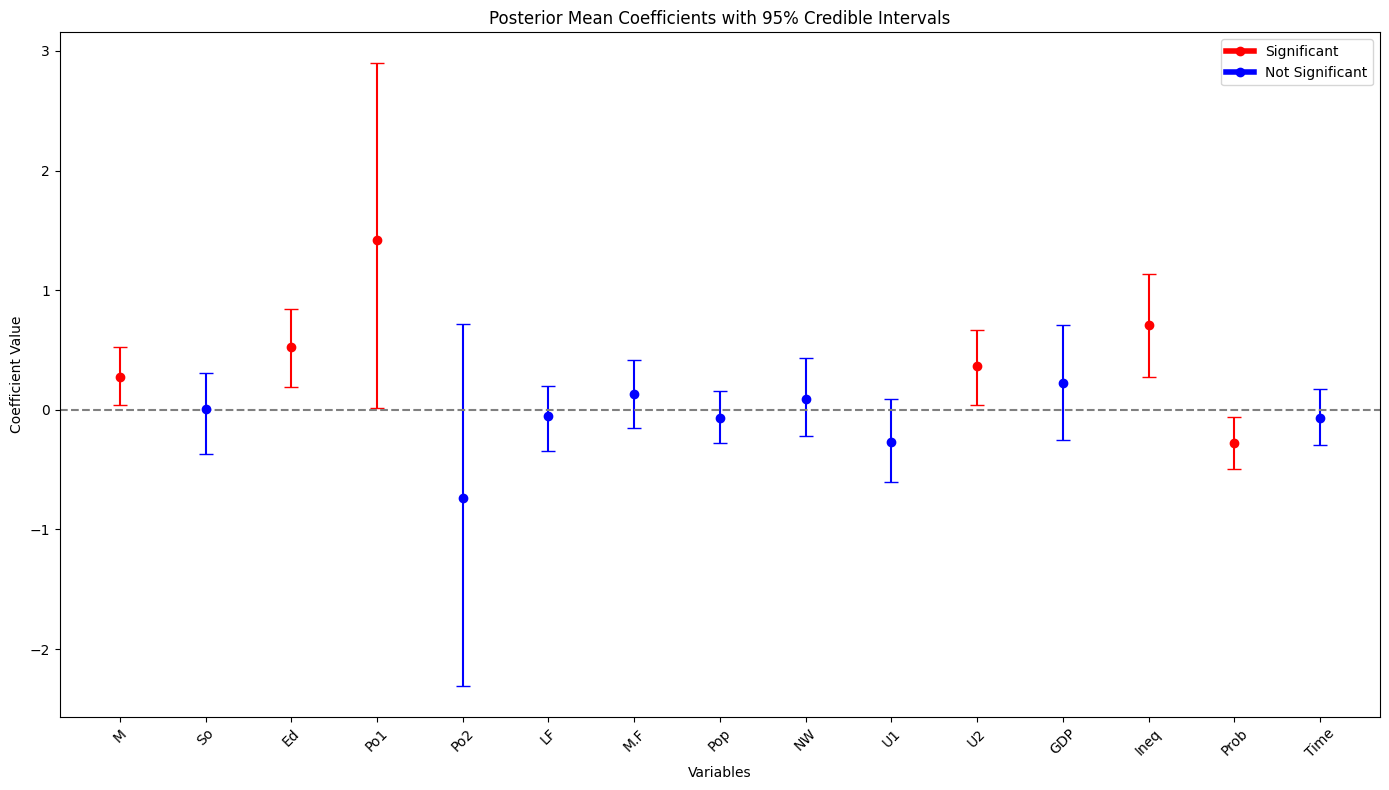

In [95]:
# Assuming df_crime is your DataFrame with the crime data
y = df_crime['y'].values
X = df_crime.drop(columns=['y']).values

n, p = X.shape

g = n
nu0 = 2
s20 = 1

S = 1000

# Calculating the hat matrix Hg
Hg = (g / (g + 1)) * X @ np.linalg.inv(X.T @ X) @ X.T
# Sum of squared residuals for g-prior
SSRg = y.T @ (np.eye(n) - Hg) @ y

# Sampling from the posterior distribution of the variance
s2 = 1 / gamma.rvs((nu0 + n) / 2, scale=2 / (nu0 * s20 + SSRg), size=S)

Vb = g * np.linalg.inv(X.T @ X) / (g + 1)
Eb = Vb @ X.T @ y

# Generating posterior samples for regression coefficients
E = norm.rvs(size=(S, p), scale=np.sqrt(s2).reshape(-1, 1))
beta = (E @ np.linalg.cholesky(Vb).T) + Eb

# Correct calculation of confidence (credible) intervals
confidence_intervals = np.percentile(beta, [2.5, 97.5], axis=0)

variable_names = df_crime.columns.drop('y')

# Calculate the errors as the absolute differences between the bounds and the means
lower_errors = posterior_means - confidence_intervals[0, :]
upper_errors = confidence_intervals[1, :] - posterior_means

# Calculate significance based on 95% credible intervals not crossing zero
signif = (confidence_intervals[0, :] > 0) | (confidence_intervals[1, :] < 0)

# Set up the figure for plotting
plt.figure(figsize=(14, 8))

# Assign colors based on significance
colors = ['red' if is_signif else 'blue' for is_signif in signif]

# Plotting each variable with its posterior mean and corresponding 95% CI, color-coded by significance
for i, var_name in enumerate(variable_names):
    plt.errorbar(x=i, y=posterior_means[i], yerr=[[lower_errors[i]], [upper_errors[i]]],
                 fmt='o', capsize=5, ecolor=colors[i], color=colors[i], label='Significant' if colors[i] == 'red' else 'Not Significant')

# Add some plot aesthetics
plt.xticks(ticks=range(len(variable_names)), labels=variable_names, rotation=45)
plt.axhline(0, color='grey', linestyle='--')
plt.title('Posterior Mean Coefficients with 95% Credible Intervals')
plt.ylabel('Coefficient Value')
plt.xlabel('Variables')

# Create custom legends

custom_lines = [Line2D([0], [0], color='red', lw=4, marker='o'),
                Line2D([0], [0], color='blue', lw=4, marker='o')]
plt.legend(custom_lines, ['Significant', 'Not Significant'])

plt.tight_layout()
plt.show()


## b)

      Coefficient
M        0.335137
So      -0.284821
Ed      -0.289066
Po1      0.368477
Po2      0.683263
LF       0.021319
M.F      0.397005
Pop      0.104285
NW      -0.435863
U1      -0.072960
U2       0.177923
GDP      0.198156
Ineq     0.944201
Prob    -0.036701
Time    -0.014479


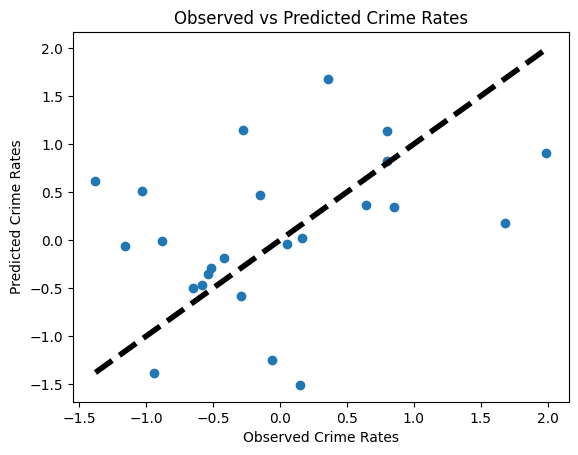

Prediction Error: 0.8744081292365546


In [101]:
# Prepare the data
y = df_crime['y'].values
X = df_crime.drop('y', axis=1).values

# Set a seed for reproducibility
np.random.seed(1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Fit a least squares regression model
beta_ols = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Print the regression coefficients in a similar format to R
variable_names = df_crime.drop('y', axis=1).columns
beta_ols_df = pd.DataFrame(beta_ols, index=variable_names, columns=['Coefficient'])
print(beta_ols_df)

# Obtain predicted values for the test data
y_ols_pred = X_test @ beta_ols

# Plot y_test vs y_ols_pred
plt.scatter(y_test, y_ols_pred)
plt.xlabel('Observed Crime Rates')
plt.ylabel('Predicted Crime Rates')
plt.title('Observed vs Predicted Crime Rates')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.show()

# Compute the prediction error
pred_error = np.mean((y_test - y_ols_pred) ** 2)
print(f"Prediction Error: {pred_error}")

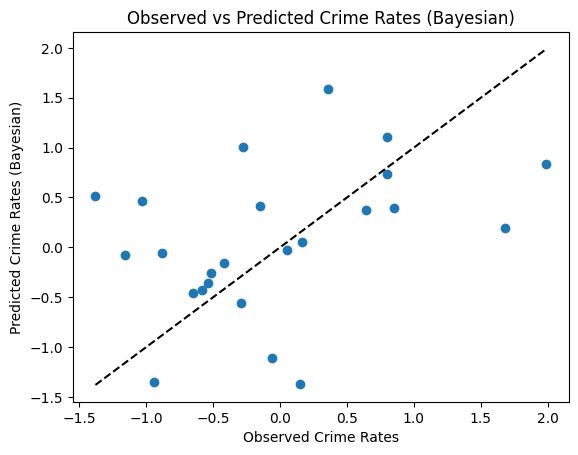

Bayesian Prediction Error: 0.7910944869660504


In [113]:
n, p = X_train.shape
g = n
nu0 = 2
s20 = 1
S = 1000

# Compute the hat matrix
Hg = (g / (g + 1)) * X_train @ np.linalg.inv(X_train.T @ X_train) @ X_train.T
# Compute the sum of squared residuals
SSRg = y_train.T @ (np.eye(n) - Hg) @ y_train

# Sample from the inverse gamma to get posterior of sigma^2
s2_samples = invgamma.rvs((nu0 + n) / 2, scale=(nu0 * s20 + SSRg) / 2, size=S)

# Compute the variance-covariance matrix of the beta coefficients
Vb = g * np.linalg.inv(X_train.T @ X_train) / (g + 1)
# Compute the expected value of beta coefficients
Eb = Vb @ X_train.T @ y_train

# Generate posterior samples for beta coefficients
E_samples = norm.rvs(size=(S, p), scale=np.sqrt(s2_samples).reshape(-1, 1))
beta_samples = (E_samples @ np.linalg.cholesky(Vb).T) + Eb

# Calculate the posterior mean of beta coefficients
beta_bayes = np.mean(beta_samples, axis=0)

# Make predictions on test set
y_bayes_pred = X_test @ beta_bayes

# Plot observed vs predicted
plt.scatter(y_test, y_bayes_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Observed Crime Rates')
plt.ylabel('Predicted Crime Rates (Bayesian)')
plt.title('Observed vs Predicted Crime Rates (Bayesian)')
plt.show()

# Calculate the prediction error
pred_error_bayes = np.mean((y_test - y_bayes_pred) ** 2)
print(f"Bayesian Prediction Error: {pred_error_bayes}")

## c)

In [120]:
def calculate_ols_prediction_error(X_train, y_train, X_test, y_test):
    beta_ols = inv(X_train.T @ X_train) @ X_train.T @ y_train
    y_ols_pred = X_test @ beta_ols
    return np.mean((y_test - y_ols_pred) ** 2)

def calculate_bayesian_prediction_error(X_train, y_train, X_test, y_test, g, nu0, s20, S):
    n, p = X_train.shape
    Hg = (g / (g + 1)) * X_train @ inv(X_train.T @ X_train) @ X_train.T
    SSRg = y_train.T @ (np.eye(n) - Hg) @ y_train

    s2_samples = invgamma.rvs((nu0 + n) / 2, scale=(nu0 * s20 + SSRg) / 2, size=S)
    Vb = g * inv(X_train.T @ X_train) / (g + 1)
    Eb = Vb @ X_train.T @ y_train

    E_samples = norm.rvs(size=(S, p), scale=np.sqrt(s2_samples).reshape(-1, 1))
    beta_samples = (E_samples @ np.linalg.cholesky(Vb).T) + Eb
    beta_bayes = np.mean(beta_samples, axis=0)

    y_bayes_pred = X_test @ beta_bayes
    return np.mean((y_test - y_bayes_pred) ** 2)

# Hyperparameters for Bayesian regression
g = n
nu0 = 2
s20 = 1
S = 1000

# Number of repetitions
n_repetitions = 100

# Store the prediction errors
ols_errors = []
bayes_errors = []

for _ in range(n_repetitions):
    # Randomly split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_crime.drop('y', axis=1).values, df_crime['y'].values, test_size=0.5)

    # Calculate and store the OLS prediction error
    ols_error = calculate_ols_prediction_error(X_train, y_train, X_test, y_test)
    ols_errors.append(ols_error)

    # Calculate and store the Bayesian prediction error
    bayes_error = calculate_bayesian_prediction_error(X_train, y_train, X_test, y_test, g, nu0, s20, S)
    bayes_errors.append(bayes_error)

# Compute the average prediction errors
average_ols_error = np.mean(ols_errors)
average_bayes_error = np.mean(bayes_errors)

print(f"Average OLS Prediction Error: {average_ols_error}")
print(f"Average Bayesian Prediction Error: {average_bayes_error}")


Average OLS Prediction Error: 0.9831911253823855
Average Bayesian Prediction Error: 0.928424671049076


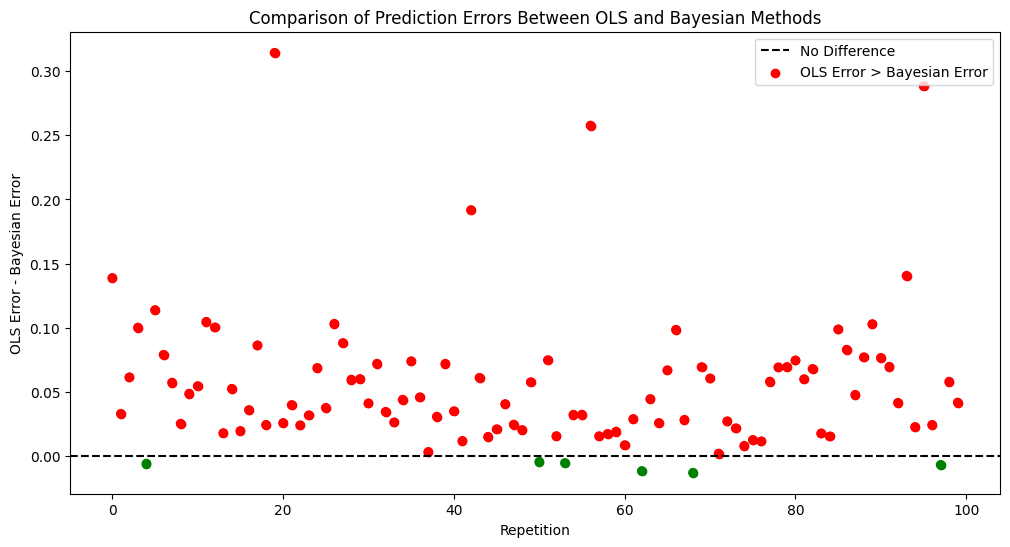

In [125]:

# Assuming ols_errors and bayes_errors are lists containing the prediction errors
# for each repetition for OLS and Bayesian methods, respectively.

# Calculate the differences between OLS and Bayesian prediction errors
error_differences = np.array(ols_errors) - np.array(bayes_errors)

# Assign colors based on whether the OLS error is greater than the Bayesian error
colors = ['red' if diff > 0 else 'green' for diff in error_differences]

# Plot the differences in prediction errors
plt.figure(figsize=(12, 6))
plt.scatter(range(len(error_differences)), error_differences, c=colors)
plt.axhline(0, color='black', linestyle='--', label='No Difference')

# Highlight the points where OLS error is greater
for i, diff in enumerate(error_differences):
    if diff > 0:
        plt.scatter(i, diff, c='red', label='OLS Error > Bayesian Error' if i == 0 else "")
    else:
        plt.scatter(i, diff, c='green', label='Bayesian Error > OLS Error' if i == 0 else "")

plt.xlabel('Repetition')
plt.ylabel('OLS Error - Bayesian Error')
plt.title('Comparison of Prediction Errors Between OLS and Bayesian Methods')
plt.legend()
plt.show()

# Problem 3: Exercise 10.5

In [135]:
# String data
data = """npreg glu bp skin bmi ped age diabetes
 5     86    68   28    30.2  0.364 24    No
 7    195    70   33    25.1  0.163 55    Yes
 5     77    82   41    35.8  0.156 35    No
 0    165    76   43    47.9  0.259 26    No
 0    107    60   25    26.4  0.133 23    No
 5     97    76   27    35.6  0.378 52    Yes
 3     83    58   31    34.3  0.336 25    No
 1    193    50   16    25.9  0.655 24    No
 3    142    80   15    32.4  0.200 63    No
 2    128    78   37    43.3  1.224 31    Yes
 0    137    40   35    43.1  2.288 33    Yes
 9    154    78   30    30.9  0.164 45    No
 1    189    60   23    30.1  0.398 59    Yes
12     92    62    7    27.6  0.926 44    Yes
 1     86    66   52    41.3  0.917 29    No
 4     99    76   15    23.2  0.223 21    No
 1    109    60    8    25.4  0.947 21    No
11    143    94   33    36.6  0.254 51    Yes
 1    149    68   29    29.3  0.349 42    Yes
 0    139    62   17    22.1  0.207 21    No
 2     99    70   16    20.4  0.235 27    No
 1    100    66   29    32.0  0.444 42    No
 4     83    86   19    29.3  0.317 34    No
 0    101    64   17    21.0  0.252 21    No
 1     87    68   34    37.6  0.401 24    No
 9    164    84   21    30.8  0.831 32    Yes
 1     99    58   10    25.4  0.551 21    No
 0    140    65   26    42.6  0.431 24    Yes
 5    108    72   43    36.1  0.263 33    No
 2    110    74   29    32.4  0.698 27    No
 1     79    60   42    43.5  0.678 23    No
 3    148    66   25    32.5  0.256 22    No
 0    121    66   30    34.3  0.203 33    Yes
 3    158    64   13    31.2  0.295 24    No
 2    105    80   45    33.7  0.711 29    Yes
13    145    82   19    22.2  0.245 57    No
 1     79    80   25    25.4  0.583 22    No
 1     71    48   18    20.4  0.323 22    No
 0    102    86   17    29.3  0.695 27    No
 0    119    66   27    38.8  0.259 22    No
 8    176    90   34    33.7  0.467 58    Yes
 1     97    68   21    27.2  1.095 22    No
 4    129    60   12    27.5  0.527 31    No
 1     97    64   19    18.2  0.299 21    No
 0     86    68   32    35.8  0.238 25    No
 2    125    60   20    33.8  0.088 31    No
 5    123    74   40    34.1  0.269 28    No
 2     92    76   20    24.2  1.698 28    No
 3    171    72   33    33.3  0.199 24    Yes
 1    199    76   43    42.9  1.394 22    Yes
 3    116    74   15    26.3  0.107 24    No
 2     83    66   23    32.2  0.497 22    No
 8    154    78   32    32.4  0.443 45    Yes
 1    114    66   36    38.1  0.289 21    No
 1    106    70   28    34.2  0.142 22    No
 4    127    88   11    34.5  0.598 28    No
 1    124    74   36    27.8  0.100 30    No
 1    109    38   18    23.1  0.407 26    No
 2    123    48   32    42.1  0.520 26    No
 8    167   106   46    37.6  0.165 43    Yes
 7    184    84   33    35.5  0.355 41    Yes
 1     96    64   27    33.2  0.289 21    No
10    129    76   28    35.9  0.280 39    No
 6     92    62   32    32.0  0.085 46    No
 6    109    60   27    25.0  0.206 27    No
 5    139    80   35    31.6  0.361 25    Yes
 6    134    70   23    35.4  0.542 29    Yes
 3    106    54   21    30.9  0.292 24    No
 0    131    66   40    34.3  0.196 22    Yes
 0    135    94   46    40.6  0.284 26    No
 5    158    84   41    39.4  0.395 29    Yes
 3    112    74   30    31.6  0.197 25    Yes
 8    181    68   36    30.1  0.615 60    Yes
 2    121    70   32    39.1  0.886 23    No
 1    168    88   29    35.0  0.905 52    Yes
 1    144    82   46    46.1  0.335 46    Yes
 2    101    58   17    24.2  0.614 23    No
 2     96    68   13    21.1  0.647 26    No
 3    107    62   13    22.9  0.678 23    Yes
12    121    78   17    26.5  0.259 62    No
 2    100    64   23    29.7  0.368 21    No
 4    154    72   29    31.3  0.338 37    No
 6    125    78   31    27.6  0.565 49    Yes
10    125    70   26    31.1  0.205 41    Yes
 2    122    76   27    35.9  0.483 26    No
 2    114    68   22    28.7  0.092 25    No
 1    115    70   30    34.6  0.529 32    Yes
 7    114    76   17    23.8  0.466 31    No
 2    115    64   22    30.8  0.421 21    No
 1    130    60   23    28.6  0.692 21    No
 1     79    75   30    32.0  0.396 22    No
 4    112    78   40    39.4  0.236 38    No
 7    150    78   29    35.2  0.692 54    Yes
 1     91    54   25    25.2  0.234 23    No
 1    100    72   12    25.3  0.658 28    No
12    140    82   43    39.2  0.528 58    Yes
 4    110    76   20    28.4  0.118 27    No
 2     94    76   18    31.6  0.649 23    No
 2     84    50   23    30.4  0.968 21    No
10    148    84   48    37.6  1.001 51    Yes
 3     61    82   28    34.4  0.243 46    No
 4    117    62   12    29.7  0.380 30    Yes
 3     99    80   11    19.3  0.284 30    No
 3     80    82   31    34.2  1.292 27    Yes
 4    154    62   31    32.8  0.237 23    No
 6    103    72   32    37.7  0.324 55    No
 6    111    64   39    34.2  0.260 24    No
 0    124    70   20    27.4  0.254 36    Yes
 1    143    74   22    26.2  0.256 21    No
 1     81    74   41    46.3  1.096 32    No
 4    189   110   31    28.5  0.680 37    No
 4    116    72   12    22.1  0.463 37    No
 7    103    66   32    39.1  0.344 31    Yes
 8    124    76   24    28.7  0.687 52    Yes
 1     71    78   50    33.2  0.422 21    No
 0    137    84   27    27.3  0.231 59    No
 9    112    82   32    34.2  0.260 36    Yes
 4    148    60   27    30.9  0.150 29    Yes
 1    136    74   50    37.4  0.399 24    No
 9    145    80   46    37.9  0.637 40    Yes
 1     93    56   11    22.5  0.417 22    No
 1    107    72   30    30.8  0.821 24    No
12    151    70   40    41.8  0.742 38    Yes
 1     97    70   40    38.1  0.218 30    No
 5    144    82   26    32.0  0.452 58    Yes
 2    112    86   42    38.4  0.246 28    No
 2     99    52   15    24.6  0.637 21    No
 1    109    56   21    25.2  0.833 23    No
 1    120    80   48    38.9  1.162 41    No
 7    187    68   39    37.7  0.254 41    Yes
 3    129    92   49    36.4  0.968 32    Yes
 7    179    95   31    34.2  0.164 60    No
 6     80    66   30    26.2  0.313 41    No
 2    105    58   40    34.9  0.225 25    No
 3    191    68   15    30.9  0.299 34    No
 0     95    80   45    36.5  0.330 26    No
 4     99    72   17    25.6  0.294 28    No
 0    137    68   14    24.8  0.143 21    No
 1     97    70   15    18.2  0.147 21    No
 0    100    88   60    46.8  0.962 31    No
 1    167    74   17    23.4  0.447 33    Yes
 0    180    90   26    36.5  0.314 35    Yes
 2    122    70   27    36.8  0.340 27    No
 1     90    62   12    27.2  0.580 24    No
 3    120    70   30    42.9  0.452 30    No
 6    154    78   41    46.1  0.571 27    No
 2     56    56   28    24.2  0.332 22    No
 0    177    60   29    34.6  1.072 21    Yes
 3    124    80   33    33.2  0.305 26    No
 8     85    55   20    24.4  0.136 42    No
12     88    74   40    35.3  0.378 48    No
 9    152    78   34    34.2  0.893 33    Yes
 0    198    66   32    41.3  0.502 28    Yes
 0    188    82   14    32.0  0.682 22    Yes
 5    139    64   35    28.6  0.411 26    No
 7    168    88   42    38.2  0.787 40    Yes
 2    197    70   99    34.7  0.575 62    Yes
 2    142    82   18    24.7  0.761 21    No
 8    126    74   38    25.9  0.162 39    No
 3    158    76   36    31.6  0.851 28    Yes
 3    130    78   23    28.4  0.323 34    Yes
 2    100    54   28    37.8  0.498 24    No
 1    164    82   43    32.8  0.341 50    No
 4     95    60   32    35.4  0.284 28    No
 2    122    52   43    36.2  0.816 28    No
 4     85    58   22    27.8  0.306 28    No
 0    151    90   46    42.1  0.371 21    Yes
 6    144    72   27    33.9  0.255 40    No
 3    111    90   12    28.4  0.495 29    No
 1    107    68   19    26.5  0.165 24    No
 6    115    60   39    33.7  0.245 40    Yes
 5    105    72   29    36.9  0.159 28    No
 7    194    68   28    35.9  0.745 41    Yes
 4    184    78   39    37.0  0.264 31    Yes
 0     95    85   25    37.4  0.247 24    Yes
 7    124    70   33    25.5  0.161 37    No
 1    111    62   13    24.0  0.138 23    No
 7    137    90   41    32.0  0.391 39    No
 9     57    80   37    32.8  0.096 41    No
 2    157    74   35    39.4  0.134 30    No
 2     95    54   14    26.1  0.748 22    No
12    140    85   33    37.4  0.244 41    No
 0    117    66   31    30.8  0.493 22    No
 8    100    74   40    39.4  0.661 43    Yes
 9    123    70   44    33.1  0.374 40    No
 0    138    60   35    34.6  0.534 21    Yes
14    100    78   25    36.6  0.412 46    Yes
14    175    62   30    33.6  0.212 38    Yes
 0     74    52   10    27.8  0.269 22    No
 1    133   102   28    32.8  0.234 45    Yes
 0    119    64   18    34.9  0.725 23    No
 5    155    84   44    38.7  0.619 34    No
 1    128    48   45    40.5  0.613 24    Yes
 2    112    68   22    34.1  0.315 26    No
 1    140    74   26    24.1  0.828 23    No
 2    141    58   34    25.4  0.699 24    No
 7    129    68   49    38.5  0.439 43    Yes
 0    106    70   37    39.4  0.605 22    No
 1    118    58   36    33.3  0.261 23    No
 8    155    62   26    34.0  0.543 46    Yes
 2    134    70   NA    28.9  0.542 23    Yes
10     75    82   NA    33.3  0.263 38    No
 0    146    70   NA    37.9  0.334 28    Yes
 1    180   NA    NA    43.3  0.282 41    Yes
 5    104    74   NA    28.8  0.153 48    No
 9    164    78   NA    32.8  0.148 45    Yes
 1     80    55   NA    19.1  0.258 21    No
 4    171    72   NA    43.6  0.479 26    Yes
 3    139    54   NA    25.6  0.402 22    Yes
 3    122    78   NA    23.0  0.254 40    No
 5    116    74   NA    25.6  0.201 30    No
 6    195    70   NA    30.9  0.328 31    Yes
 8    125    96   NA    NA    0.232 54    Yes
 4    122    68   NA    35.0  0.394 29    No
 0    107    76   NA    45.3  0.686 24    No
 1    151    60   NA    26.1  0.179 22    No
 9    165    88   NA    30.4  0.302 49    Yes
10    168    74   NA    38.0  0.537 34    Yes
 3    102    74   NA    29.5  0.121 32    No
13     76    60   NA    32.8  0.180 41    No
 5    143    78   NA    45.0  0.190 47    No
 6    124    72   NA    27.6  0.368 29    Yes
 8     95    72   NA    36.8  0.485 57    No
 3     78    70   NA    32.5  0.270 39    No
 5    112    66   NA    37.8  0.261 41    Yes
 5     73    60   NA    26.8  0.268 27    No
 0    102    52   NA    25.1  0.078 21    No
 2    109    92   NA    42.7  0.845 54    No
 4    114    65   NA    21.9  0.432 37    No
 0    102    75   23    NA    0.572 21    No
10    133    68   NA    27.0  0.245 36    No
 4    118    70   NA    44.5  0.904 26    No
 7    136    90   NA    29.9  0.210 50    No
 7    100   NA    NA    30.0  0.484 32    Yes
 1    138    82   NA    40.1  0.236 28    No
 0    131   NA    NA    43.2  0.270 26    Yes
 2    111    60   NA    26.2  0.343 23    No
 7    133    84   NA    40.2  0.696 37    No
 6    137    61   NA    24.2  0.151 55    No
 5    115    98   NA    52.9  0.209 28    Yes
 3    125    58   NA    31.6  0.151 24    No
 4    142    86   NA    44.0  0.645 22    Yes
 4    146    92   NA    31.2  0.539 61    Yes
 4    128    70   NA    34.3  0.303 24    No
 0    132    78   NA    32.4  0.393 21    No
 4    134    72   NA    23.8  0.277 60    Yes
 2    120    54   NA    26.8  0.455 27    No
 0    111    65   NA    24.6  0.660 31    No
 2    139    75   NA    25.6  0.167 29    No
 1    106    76   NA    37.5  0.197 26    No
 6    147    80   NA    29.5  0.178 50    Yes
 8    107    80   NA    24.6  0.856 34    No
 4    183   NA    NA    28.4  0.212 36    Yes
 6     96   NA    NA    23.7  0.190 28    No
 4    158    78   NA    32.9  0.803 31    Yes
11    127   106   NA    39.0  0.190 51    No
 6     87    80   NA    23.2  0.084 32    No
 4    123    62   NA    32.0  0.226 35    Yes
 2    118    80   NA    42.9  0.693 21    Yes
 6    103    66   NA    24.3  0.249 29    No
 4    110    66   NA    31.9  0.471 29    No
 5    147    78   NA    33.7  0.218 65    No
 0    119   NA    NA    32.4  0.141 24    Yes
 4    156    75   NA    48.3  0.238 32    Yes
 8    197    74   NA    25.9  1.191 39    Yes
 6    102    82   NA    30.8  0.180 36    Yes
 0    131    88   NA    31.6  0.743 32    Yes
 5    136    82   NA    NA    0.640 69    No
13    158   114   NA    42.3  0.257 44    Yes
 0     93    60   NA    35.3  0.263 25    No
 2     87   NA    23    28.9  0.773 25    No
10    108    66   NA    32.4  0.272 42    Yes
10    139    80   NA    27.1  1.441 57    No
 4    110    92   NA    37.6  0.191 30    No
 4    114    64   NA    28.9  0.126 24    No
 0    101    62   NA    21.9  0.336 25    No
 2     91    62   NA    27.3  0.525 22    No
 8    133    72   NA    32.9  0.270 39    Yes
 1    111    94   NA    32.8  0.265 45    No
 5    147    75   NA    29.9  0.434 28    No
 4     92    80   NA    42.2  0.237 29    No
 2     90    60   NA    23.5  0.191 25    No
 7    114    64   NA    27.4  0.732 34    Yes
 7    125    86   NA    37.6  0.304 51    No
 2    119   NA    NA    19.6  0.832 72    No
 5    115    76   NA    31.2  0.343 44    Yes
 0    141   NA    NA    42.4  0.205 29    Yes
 0    167   NA    NA    32.3  0.839 30    Yes
 4     90   NA    NA    28.0  0.610 31    No
 5    132    80   NA    26.8  0.186 69    No
 0    125    96   NA    22.5  0.262 21    No
 3    150    76   NA    21.0  0.207 37    No
 4     95    64   NA    32.0  0.161 31    Yes
 4    136    70   NA    31.2  1.182 22    Yes
 8    110    76   NA    27.8  0.237 58    No
 0    125    68   NA    24.7  0.206 21    No
 6     92    92   NA    19.9  0.188 28    No
 3    141   NA    NA    30.0  0.761 27    Yes
 0     73   NA    NA    21.1  0.342 25    No
 2    129    84   NA    28.0  0.284 27    No
 6    148    72   35    33.6  0.627 50    Yes
 1     85    66   29    26.6  0.351 31    No
 1     89    66   23    28.1  0.167 21    No
 3     78    50   32    31.0  0.248 26    Yes
 2    197    70   45    30.5  0.158 53    Yes
 5    166    72   19    25.8  0.587 51    Yes
 0    118    84   47    45.8  0.551 31    Yes
 1    103    30   38    43.3  0.183 33    No
 3    126    88   41    39.3  0.704 27    No
 9    119    80   35    29.0  0.263 29    Yes
 1     97    66   15    23.2  0.487 22    No
 5    109    75   26    36.0  0.546 60    No
 3     88    58   11    24.8  0.267 22    No
10    122    78   31    27.6  0.512 45    No
 4    103    60   33    24.0  0.966 33    No
 9    102    76   37    32.9  0.665 46    Yes
 2     90    68   42    38.2  0.503 27    Yes
 4    111    72   47    37.1  1.390 56    Yes
 3    180    64   25    34.0  0.271 26    No
 7    106    92   18    22.7  0.235 48    No
 9    171   110   24    45.4  0.721 54    Yes
 0    180    66   39    42.0  1.893 25    Yes
 2     71    70   27    28.0  0.586 22    No
 1    103    80   11    19.4  0.491 22    No
 1    101    50   15    24.2  0.526 26    No
 5     88    66   21    24.4  0.342 30    No
 7    150    66   42    34.7  0.718 42    No
 1     73    50   10    23.0  0.248 21    No
 0    105    64   41    41.5  0.173 22    No
 5     99    74   27    29.0  0.203 32    No
 0    109    88   30    32.5  0.855 38    Yes
 1     95    66   13    19.6  0.334 25    No
 4    146    85   27    28.9  0.189 27    No
 2    100    66   20    32.9  0.867 28    Yes
 4    129    86   20    35.1  0.231 23    No
 5     95    72   33    37.7  0.370 27    No
 2    112    66   22    25.0  0.307 24    No
 3    113    44   13    22.4  0.140 22    No
 7     83    78   26    29.3  0.767 36    No
 0    101    65   28    24.6  0.237 22    No
13    106    72   54    36.6  0.178 45    No
 2    100    68   25    38.5  0.324 26    No
15    136    70   32    37.1  0.153 43    Yes
 4    123    80   15    32.0  0.443 34    No
 7     81    78   40    46.7  0.261 42    No
 2     92    62   28    31.6  0.130 24    No
 6     93    50   30    28.7  0.356 23    No
 1    122    90   51    49.7  0.325 31    Yes
 1     81    72   18    26.6  0.283 24    No
 1    126    56   29    28.7  0.801 21    No
 4    144    58   28    29.5  0.287 37    No
 1     89    76   34    31.2  0.192 23    No
 7    160    54   32    30.5  0.588 39    Yes
 4     97    60   23    28.2  0.443 22    No
 0    162    76   56    53.2  0.759 25    Yes
 2    107    74   30    33.6  0.404 23    No
 1     88    30   42    55.0  0.496 26    Yes
 1    117    88   24    34.5  0.403 40    Yes
 4    173    70   14    29.7  0.361 33    Yes
 3    170    64   37    34.5  0.356 30    Yes
 8     84    74   31    38.3  0.457 39    No
 0    100    70   26    30.8  0.597 21    No
 0     93    60   25    28.7  0.532 22    No
 5    106    82   30    39.5  0.286 38    No
 2    108    52   26    32.5  0.318 22    No
 2    106    64   35    30.5  1.400 34    No
 2     90    70   17    27.3  0.085 22    No
 9    156    86   28    34.3  1.189 42    Yes
 1    153    82   42    40.6  0.687 23    No
 7    152    88   44    50.0  0.337 36    Yes
 2     88    74   19    29.0  0.229 22    No
17    163    72   41    40.9  0.817 47    Yes
 4    151    90   38    29.7  0.294 36    No
 7    102    74   40    37.2  0.204 45    No
 0    114    80   34    44.2  0.167 27    No
 6    104    74   18    29.9  0.722 41    Yes
 2     75    64   24    29.7  0.370 33    No
 8    179    72   42    32.7  0.719 36    Yes
 0    129   110   46    67.1  0.319 26    Yes
 1    128    98   41    32.0  1.321 33    Yes
 8    109    76   39    27.9  0.640 31    Yes
 4    109    64   44    34.8  0.905 26    Yes
 0    113    80   16    31.0  0.874 21    No
 0    108    68   20    27.3  0.787 32    No
 5    111    72   28    23.9  0.407 27    No
 8    196    76   29    37.5  0.605 57    Yes
 2     81    60   22    27.7  0.290 25    No
 0    147    85   54    42.8  0.375 24    No
 5    109    62   41    35.8  0.514 25    Yes
 6    125    68   30    30.0  0.464 32    No
 5     85    74   22    29.0  1.224 32    Yes
 7    142    60   33    28.8  0.687 61    No
 1    100    66   15    23.6  0.666 26    No
 1     87    78   27    34.6  0.101 22    No
 3    162    52   38    37.2  0.652 24    Yes
 4    197    70   39    36.7  2.329 31    No
 0    117    80   31    45.2  0.089 24    No
 6    134    80   37    46.2  0.238 46    Yes
 3     74    68   28    29.7  0.293 23    No
 7    181    84   21    35.9  0.586 51    Yes
 0    179    90   27    44.1  0.686 23    Yes
 1     91    64   24    29.2  0.192 21    No
 4     91    70   32    33.1  0.446 22    No
 6    119    50   22    27.1  1.318 33    Yes
 2    146    76   35    38.2  0.329 29    No
 9    184    85   15    30.0  1.213 49    Yes
 0    165    90   33    52.3  0.427 23    No
 9    124    70   33    35.4  0.282 34    No
 1    111    86   19    30.1  0.143 23    No
 2     90    80   14    24.4  0.249 24    No
 1    113    64   35    33.6  0.543 21    Yes
 3    111    56   39    30.1  0.557 30    No
11    155    76   28    33.3  1.353 51    Yes
 4     95    70   32    32.1  0.612 24    No
 5     96    74   18    33.6  0.997 43    No
 2    128    64   42    40.0  1.101 24    No
10    101    86   37    45.6  1.136 38    Yes
 2    108    62   32    25.2  0.128 21    No
 2    100    70   52    40.5  0.677 25    No
 7    106    60   24    26.5  0.296 29    Yes
 0    104    64   23    27.8  0.454 23    No
 2    108    62   10    25.3  0.881 22    No
 7    133    88   15    32.4  0.262 37    No
 7    136    74   26    26.0  0.647 51    No
 1    119    86   39    45.6  0.808 29    Yes
 4     96    56   17    20.8  0.340 26    No
 0     78    88   29    36.9  0.434 21    No
 0    107    62   30    36.6  0.757 25    Yes
 6    151    62   31    35.5  0.692 28    No
 2    146    70   38    28.0  0.337 29    Yes
 0    126    84   29    30.7  0.520 24    No
 2    144    58   33    31.6  0.422 25    Yes
 2    120    76   37    39.7  0.215 29    No
10    161    68   23    25.5  0.326 47    Yes
 0    128    68   19    30.5  1.391 25    Yes
 2    124    68   28    32.9  0.875 30    Yes
 2    155    74   17    26.6  0.433 27    Yes
 3    113    50   10    29.5  0.626 25    No
 7    109    80   31    35.9  1.127 43    Yes
 3    115    66   39    38.1  0.150 28    No
13    152    90   33    26.8  0.731 43    Yes
 2    112    75   32    35.7  0.148 21    No
 1    157    72   21    25.6  0.123 24    No
 1    122    64   32    35.1  0.692 30    Yes
 2    102    86   36    45.5  0.127 23    Yes
 6    105    70   32    30.8  0.122 37    No
 8    118    72   19    23.1  1.476 46    No
 2     87    58   16    32.7  0.166 25    No
 1     95    60   18    23.9  0.260 22    No
 1    130    70   13    25.9  0.472 22    No
 1     95    74   21    25.9  0.673 36    No
 8    126    88   36    38.5  0.349 49    No
 1    139    46   19    28.7  0.654 22    No
 3     99    62   19    21.8  0.279 26    No
 1    125    50   40    33.3  0.962 28    Yes
 1    196    76   36    36.5  0.875 29    Yes
 5    189    64   33    31.2  0.583 29    Yes
 5    103   108   37    39.2  0.305 65    No
 4    147    74   25    34.9  0.385 30    No
 5     99    54   28    34.0  0.499 30    No
 3     81    86   16    27.5  0.306 22    No
 3    173    82   48    38.4  2.137 25    Yes
 0     84    64   22    35.8  0.545 21    No
 0     98    82   15    25.2  0.299 22    No
 1     87    60   37    37.2  0.509 22    No
 0     93   100   39    43.4  1.021 35    No
 0    105    68   22    20.0  0.236 22    No
 1     90    62   18    25.1  1.268 25    No
 1    125    70   24    24.3  0.221 25    No
 1    119    54   13    22.3  0.205 24    No
 5    116    74   29    32.3  0.660 35    Yes
 8    105   100   36    43.3  0.239 45    Yes
 3    100    68   23    31.6  0.949 28    No
 1    131    64   14    23.7  0.389 21    No
 2    127    58   24    27.7  1.600 25    No
 3     96    56   34    24.7  0.944 39    No
 3    193    70   31    34.9  0.241 25    Yes
 5    136    84   41    35.0  0.286 35    Yes
 9     72    78   25    31.6  0.280 38    No
 1    172    68   49    42.4  0.702 28    Yes
 6    102    90   39    35.7  0.674 28    No
 1    112    72   30    34.4  0.528 25    No
 1    143    84   23    42.4  1.076 22    No
 3    173    84   33    35.7  0.258 22    Yes
 4    144    82   32    38.5  0.554 37    Yes
 3    129    64   29    26.4  0.219 28    Yes
 1    119    88   41    45.3  0.507 26    No
 2     94    68   18    26.0  0.561 21    No
 0    102    64   46    40.6  0.496 21    No
 8    151    78   32    42.9  0.516 36    Yes
 1    181    64   30    34.1  0.328 38    Yes
 1     95    82   25    35.0  0.233 43    Yes
 3     89    74   16    30.4  0.551 38    No
 1     80    74   11    30.0  0.527 22    No
 1     90    68    8    24.5  1.138 36    No
 0    189   104   25    34.3  0.435 41    Yes
 4    117    64   27    33.2  0.230 24    No
 0    180    78   63    59.4  2.420 25    Yes
 0    104    64   37    33.6  0.510 22    Yes
 0    120    74   18    30.5  0.285 26    No
 1     82    64   13    21.2  0.415 23    No
 0     91    68   32    39.9  0.381 25    No
 9    134    74   33    25.9  0.460 81    No
 9    120    72   22    20.8  0.733 48    No
 8     74    70   40    35.3  0.705 39    No
 5     88    78   30    27.6  0.258 37    No
 0    124    56   13    21.8  0.452 21    No
 0     97    64   36    36.8  0.600 25    No
 1    144    82   40    41.3  0.607 28    No
 0    137    70   38    33.2  0.170 22    No
 4    132    86   31    28.0  0.419 63    No
 3    158    70   30    35.5  0.344 35    Yes
 0    123    88   37    35.2  0.197 29    No
 0     84    82   31    38.2  0.233 23    No
 0    135    68   42    42.3  0.365 24    Yes
 1    139    62   41    40.7  0.536 21    No
 0    173    78   32    46.5  1.159 58    No
 2     83    65   28    36.8  0.629 24    No
 2     89    90   30    33.5  0.292 42    No
 4     99    68   38    32.8  0.145 33    No
 4    125    70   18    28.9  1.144 45    Yes
 2     81    72   15    30.1  0.547 25    No
 6    154    74   32    29.3  0.839 39    No
 2    117    90   19    25.2  0.313 21    No
 3     84    72   32    37.2  0.267 28    No
 7     94    64   25    33.3  0.738 41    No
 3     96    78   39    37.3  0.238 40    No
12     84    72   31    29.7  0.297 46    Yes
 3     99    54   19    25.6  0.154 24    No
 3    163    70   18    31.6  0.268 28    Yes
 9    145    88   34    30.3  0.771 53    Yes
 6    129    90    7    19.6  0.582 60    No
 2     68    70   32    25.0  0.187 25    No
 3     87    60   18    21.8  0.444 21    No
 2    122    60   18    29.8  0.717 22    No
 1     77    56   30    33.3  1.251 24    No
 0    127    80   37    36.3  0.804 23    No
 3    128    72   25    32.4  0.549 27    Yes
10     90    85   32    34.9  0.825 56    Yes
 4     84    90   23    39.5  0.159 25    No
 1     88    78   29    32.0  0.365 29    No
 8    186    90   35    34.5  0.423 37    Yes
 5    187    76   27    43.6  1.034 53    Yes
 4    131    68   21    33.1  0.160 28    No
 1    116    70   28    27.4  0.204 21    No
 3     84    68   30    31.9  0.591 25    No
 1     88    62   24    29.9  0.422 23    No
 1     84    64   23    36.9  0.471 28    No
11    103    68   40    46.2  0.126 42    No
 6     99    60   19    26.9  0.497 32    No
 1     99    72   30    38.6  0.412 21    No
 3    111    58   31    29.5  0.430 22    No
 2     98    60   17    34.7  0.198 22    No
 1    143    86   30    30.1  0.892 23    No
 1    119    44   47    35.5  0.280 25    No
 6    108    44   20    24.0  0.813 35    No
 3    176    86   27    33.3  1.154 52    Yes
11    111    84   40    46.8  0.925 45    Yes
 2    112    78   50    39.4  0.175 24    No
 2     82    52   22    28.5  1.699 25    No
 6    123    72   45    33.6  0.733 34    No
 1     89    24   19    27.8  0.559 21    No
 1    108    88   19    27.1  0.400 24    No
 1    124    60   32    35.8  0.514 21    No
 1    181    78   42    40.0  1.258 22    Yes
 1     92    62   25    19.5  0.482 25    No
 0    152    82   39    41.5  0.270 27    No
 3    174    58   22    32.9  0.593 36    Yes
 6    105    80   28    32.5  0.878 26    No
11    138    74   26    36.1  0.557 50    Yes
 2     68    62   13    20.1  0.257 23    No
 9    112    82   24    28.2  1.282 50    Yes
 0     94    70   27    43.5  0.347 21    No
 4     90    88   47    37.7  0.362 29    No
 4     94    65   22    24.7  0.148 21    No
 0    102    78   40    34.5  0.238 24    No
 1    128    82   17    27.5  0.115 22    No
 7     97    76   32    40.9  0.871 32    Yes
 1    100    74   12    19.5  0.149 28    No
 3    103    72   30    27.6  0.730 27    No
 0    179    50   36    37.8  0.455 22    Yes
11    136    84   35    28.3  0.260 42    Yes
 1    117    60   23    33.8  0.466 27    No
 2    155    52   27    38.7  0.240 25    Yes
 2    101    58   35    21.8  0.155 22    No
 1    112    80   45    34.8  0.217 24    No
 4    145    82   18    32.5  0.235 70    Yes
10    111    70   27    27.5  0.141 40    Yes
 6     98    58   33    34.0  0.430 43    No
 6    165    68   26    33.6  0.631 49    No
10     68   106   23    35.5  0.285 47    No
 3    123   100   35    57.3  0.880 22    No
 0    162    76   36    49.6  0.364 26    Yes
 0     95    64   39    44.6  0.366 22    No
 2    129    74   26    33.2  0.591 25    No
 1    107    50   19    28.3  0.181 29    No
 7    142    90   24    30.4  0.128 43    Yes
 3    169    74   19    29.9  0.268 31    Yes
 6     80    80   36    39.8  0.177 28    No
 2    127    46   21    34.4  0.176 22    No
 2     93    64   32    38.0  0.674 23    Yes
 5    126    78   27    29.6  0.439 40    No
10    129    62   36    41.2  0.441 38    Yes
 0    134    58   20    26.4  0.352 21    No
 7    187    50   33    33.9  0.826 34    Yes
 3    173    78   39    33.8  0.970 31    Yes
10     94    72   18    23.1  0.595 56    No
 1    108    60   46    35.5  0.415 24    No
 5    117    86   30    39.1  0.251 42    No
 1    116    78   29    36.1  0.496 25    No
 0    141    84   26    32.4  0.433 22    No
 2    174    88   37    44.5  0.646 24    Yes
 2    106    56   27    29.0  0.426 22    No
 0    126    86   27    27.4  0.515 21    No
 8     65    72   23    32.0  0.600 42    No
 2     99    60   17    36.6  0.453 21    No
11    120    80   37    42.3  0.785 48    Yes
 3    102    44   20    30.8  0.400 26    No
 1    109    58   18    28.5  0.219 22    No
13    153    88   37    40.6  1.174 39    No
12    100    84   33    30.0  0.488 46    No
 1    147    94   41    49.3  0.358 27    Yes
 3    187    70   22    36.4  0.408 36    Yes
 1    121    78   39    39.0  0.261 28    No
 3    108    62   24    26.0  0.223 25    No
 0    181    88   44    43.3  0.222 26    Yes
 1    128    88   39    36.5  1.057 37    Yes
 2     88    58   26    28.4  0.766 22    No
 9    170    74   31    44.0  0.403 43    Yes
10    101    76   48    32.9  0.171 63    No
 5    121    72   23    26.2  0.245 30    No
 1     93    70   31    30.4  0.315 23    No  """

# Read string data into a pandas DataFrame
df_azdiabetes = pd.read_csv(StringIO(data), delim_whitespace=True)

# Print the DataFrame
df_azdiabetes.head()

,npreg,glu,bp,skin,bmi,ped,age,diabetes
0,5,86,68.0,28.0,30.2,0.364,24,No
1,7,195,70.0,33.0,25.1,0.163,55,Yes
2,5,77,82.0,41.0,35.8,0.156,35,No
3,0,165,76.0,43.0,47.9,0.259,26,No
4,0,107,60.0,25.0,26.4,0.133,23,No


## a)

In [180]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Assuming df_azdiabetes is your dataframe
y = (df_azdiabetes['diabetes'] == 'Yes').astype(int).values
X = df_azdiabetes[['npreg', 'bp', 'bmi', 'ped', 'age']].values

# Handle missing values (if any) by imputing or removing rows/columns with missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(X)

# Check for zero variance and remove such columns if necessary
variances = X_imputed.var(axis=0)
if np.any(variances == 0):
    print("Zero variance features found, removing...")
    X_imputed = X_imputed[:, variances > 0]

# Now scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Continue with your analysis using X_scaled and y
X_scaled.shape

(632, 5)

In [184]:
import numpy as np
import pandas as pd
from scipy.stats import norm, bernoulli, binom
from scipy.special import expit, logit

# Assuming df_azdiabetes is your dataframe
y = (df_azdiabetes['diabetes'] == 'Yes').astype(int).values
X = df_azdiabetes[['npreg', 'bp', 'bmi', 'ped', 'age']].values


def fix(x):
    # Replace NaN and inf values with 0
    x[np.isnan(x) | np.isinf(x)] = 0
    return x

def update_beta0(gamma, beta, beta0):
    beta0_p = norm.rvs(beta0, scale=2)  # propose beta0
    pi = expit(beta0 + X[:, gamma == 1] @ beta[gamma == 1])  # pi_original
    pi_p = expit(beta0_p + X[:, gamma == 1] @ beta[gamma == 1])  # pi_proposed
    log_a = np.sum(fix(y * np.log(pi_p)) + fix((1 - y) * np.log(1 - pi_p))) + norm.logpdf(beta0_p, scale=4)  # log numerator
    log_b = np.sum(fix(y * np.log(pi)) + fix((1 - y) * np.log(1 - pi))) + norm.logpdf(beta0, scale=4)  # log denominator
    log_r = log_a - log_b
    if np.log(np.random.rand()) < log_r:
        return beta0_p
    else:
        return beta0

def update_beta(gamma, beta, beta0):
    for j in range(len(beta)):
        if gamma[j] == 1:  # Only update if gamma_j is 1
            beta_p = beta.copy()
            beta_p[j] = norm.rvs(beta[j], scale=1)  # propose beta_j
            pi = expit(beta0 + X[:, gamma == 1] @ beta[gamma == 1])  # pi_original
            pi_p = expit(beta0 + X[:, gamma == 1] @ beta_p[gamma == 1])  # pi_proposed
            log_a = np.sum(fix(y * np.log(pi_p)) + fix((1 - y) * np.log(1 - pi_p))) + norm.logpdf(beta_p[j], scale=2)  # log numerator
            log_b = np.sum(fix(y * np.log(pi)) + fix((1 - y) * np.log(1 - pi))) + norm.logpdf(beta[j], scale=2)  # log denominator
            log_r = log_a - log_b
            if np.log(np.random.rand()) < log_r:
                beta[j] = beta_p[j]
    return beta

def update_gamma(gamma, beta, beta0):
    for j in np.random.permutation(len(gamma)):
        gamma_a = gamma.copy()
        gamma_b = gamma.copy()
        gamma_a[j] = 1  # for numerator
        gamma_b[j] = 0  # for denominator
        pi_a = expit(beta0 + X[:, gamma_a == 1] @ beta[gamma_a == 1])  # pi_original
        log_a = np.sum(fix(y * np.log(pi_a)) + fix((1 - y) * np.log(1 - pi_a)))  # log numerator
        pi_b = expit(beta0 + X[:, gamma_b == 1] @ beta[gamma_b == 1])  # pi_original
        log_b = np.sum(fix(y * np.log(pi_b)) + fix((1 - y) * np.log(1 - pi_b)))  # log denominator
        log_odds = log_a - log_b
        gamma[j] = bernoulli.rvs(expit(log_odds))
    return gamma

# Initial values
p = X.shape[1]
gamma = np.ones(p, dtype=int)
beta = np.zeros(p)
beta0 = 1
S = 10500  # Total iterations
B = 500  # Burn-in

# Initialize arrays to store samples
Gamma_samples = np.zeros((S, p))
Beta_samples = np.zeros((S, p))
Beta0_samples = np.zeros(S)

# Update parameters
for i in range(S):
    beta0 = update_beta0(gamma, beta, beta0)
    beta = update_beta(gamma, beta, beta0)
    gamma = update_gamma(gamma, beta, beta0)
    Beta0_samples[i] = beta0
    Beta_samples[i, :] = beta
    Gamma_samples[i, :] = gamma

# Remove burn-in samples
Beta0_samples = Beta0_samples[B:]
Beta_samples = Beta_samples[B:, :]
Gamma_samples = Gamma_samples[B:, :]

<ipython-input-184-a138a3550b96>:35: RuntimeWarning: divide by zero encountered in log
  log_a = np.sum(fix(y * np.log(pi_p)) + fix((1 - y) * np.log(1 - pi_p))) + norm.logpdf(beta_p[j], scale=2)  # log numerator
<ipython-input-184-a138a3550b96>:35: RuntimeWarning: invalid value encountered in multiply
  log_a = np.sum(fix(y * np.log(pi_p)) + fix((1 - y) * np.log(1 - pi_p))) + norm.logpdf(beta_p[j], scale=2)  # log numerator
<ipython-input-184-a138a3550b96>:36: RuntimeWarning: divide by zero encountered in log
  log_b = np.sum(fix(y * np.log(pi)) + fix((1 - y) * np.log(1 - pi))) + norm.logpdf(beta[j], scale=2)  # log denominator
<ipython-input-184-a138a3550b96>:36: RuntimeWarning: invalid value encountered in multiply
  log_b = np.sum(fix(y * np.log(pi)) + fix((1 - y) * np.log(1 - pi))) + norm.logpdf(beta[j], scale=2)  # log denominator
<ipython-input-184-a138a3550b96>:49: RuntimeWarning: divide by zero encountered in log
  log_a = np.sum(fix(y * np.log(pi_a)) + fix((1 - y) * np.log(1 -

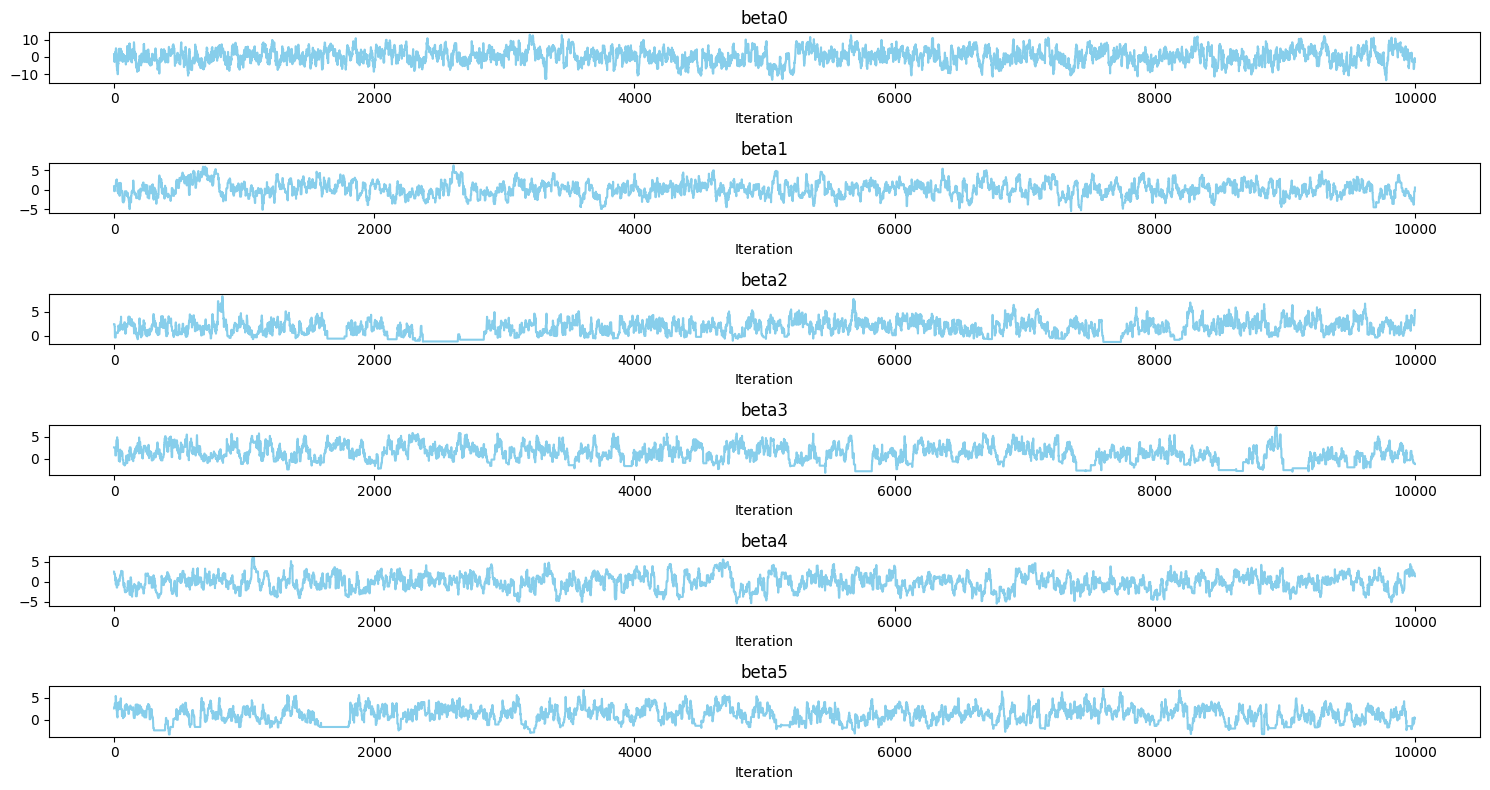

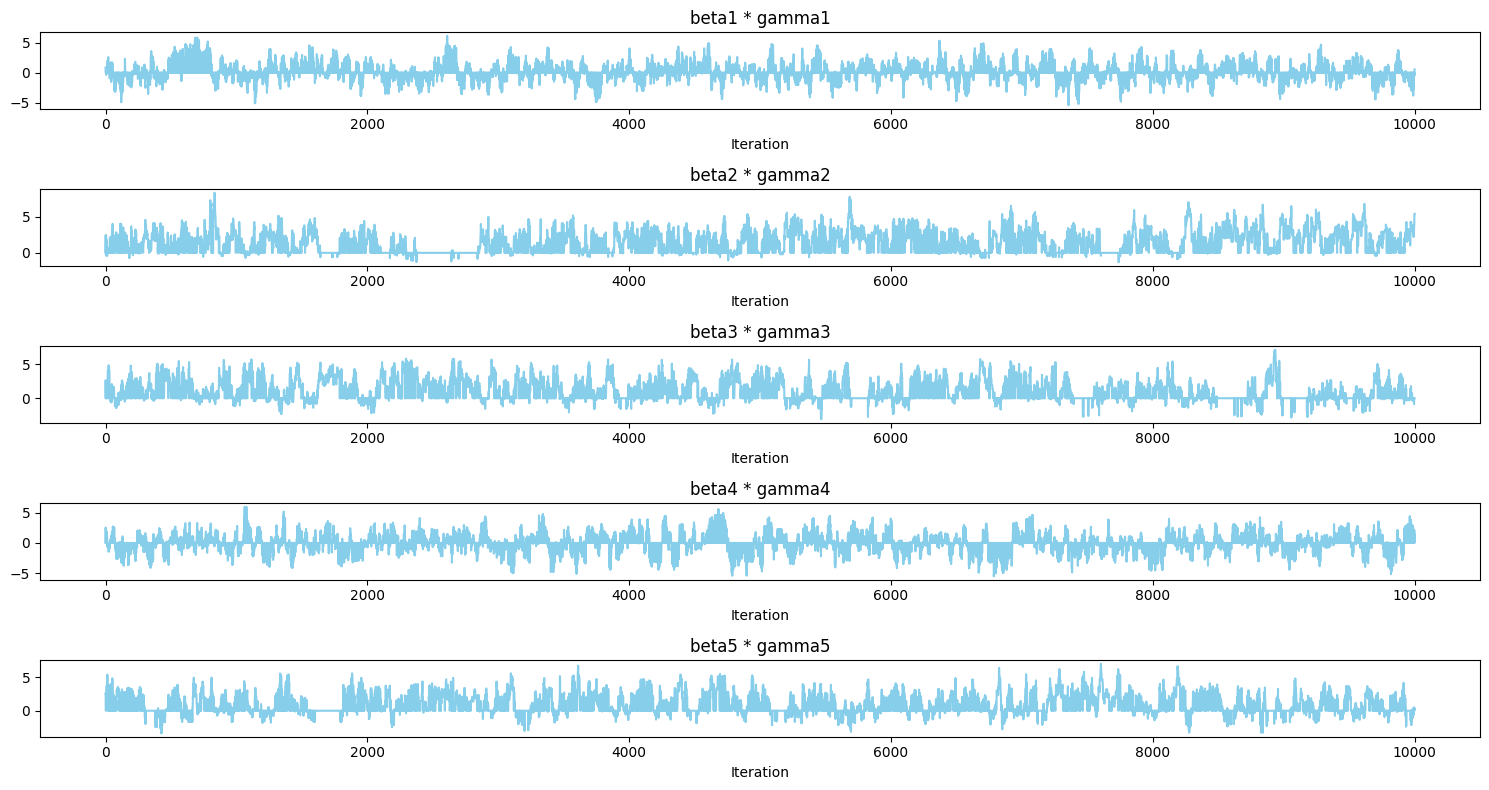

In [185]:
import matplotlib.pyplot as plt

# Assuming Beta0_samples is an array with shape (S-B, )
# And Beta_samples and Gamma_samples are arrays with shape (S-B, p)

def plot_traceplots(beta0, betas, gammas, titles):
    num_plots = betas.shape[1] + 1  # Number of plots including beta0
    plt.figure(figsize=(15, 8))

    # Plot for beta0
    plt.subplot(num_plots, 1, 1)
    plt.plot(beta0, color='skyblue')
    plt.title(titles[0])
    plt.xlabel('Iteration')

    # Plot for beta1 to betap
    for i in range(1, num_plots):
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(betas[:, i-1], color='skyblue')
        plt.title(titles[i])
        plt.xlabel('Iteration')

    plt.tight_layout()
    plt.show()

def plot_interaction_traceplots(betas, gammas, titles):
    num_plots = betas.shape[1]  # Number of beta/gamma interactions
    interactions = betas * gammas  # Element-wise multiplication for interactions
    plt.figure(figsize=(15, 8))

    for i in range(num_plots):
        plt.subplot(num_plots, 1, i + 1)
        plt.plot(interactions[:, i], color='skyblue')
        plt.title(f'{titles[i]} * gamma{i+1}')
        plt.xlabel('Iteration')

    plt.tight_layout()
    plt.show()

# Combine Beta0 and Beta samples for traceplots
combined_beta_samples = np.column_stack((Beta0_samples, Beta_samples))

# Plot the traceplots for beta coefficients
plot_traceplots(
    Beta0_samples,
    Beta_samples,
    Gamma_samples,
    ['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5']
)

# Plot the interaction traceplots for beta * gamma
plot_interaction_traceplots(
    Beta_samples,
    Gamma_samples,
    ['beta1', 'beta2', 'beta3', 'beta4', 'beta5']
)


## b)

In [186]:
# Convert the Gamma_samples array into a DataFrame for easy manipulation
gamma_df = pd.DataFrame(Gamma_samples, columns=['gamma1', 'gamma2', 'gamma3', 'gamma4', 'gamma5'])

# Create a string representation of each row of binary indicators
gamma_str = gamma_df.apply(lambda row: ''.join(row.values.astype(str)), axis=1)

# Count the occurrences of each unique combination
gamma_counts = gamma_str.value_counts()

# Get the top five most frequently occurring combinations
top5_frequencies = gamma_counts.head(5)

# Calculate the posterior probabilities
top5_probabilities = top5_frequencies / len(gamma_str)

# Display the results
print("Top 5 most frequently occurring values of γ and their posterior probabilities:")
print(top5_probabilities)

Top 5 most frequently occurring values of γ and their posterior probabilities:
1.01.01.00.01.0    0.0465
0.01.01.00.01.0    0.0463
1.01.00.00.01.0    0.0454
0.01.00.01.01.0    0.0454
0.01.00.00.01.0    0.0453
dtype: float64


## c)

                Posterior Mean  Pr(gamma_j = 1|x,y)
beta1 * gamma1        0.125321               0.4935
beta2 * gamma2        1.416332               0.6758
beta3 * gamma3        1.066009               0.5872
beta4 * gamma4       -0.057786               0.4932
beta5 * gamma5        0.957886               0.5876
Pr(y_i = 1|x_i) for all samples:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


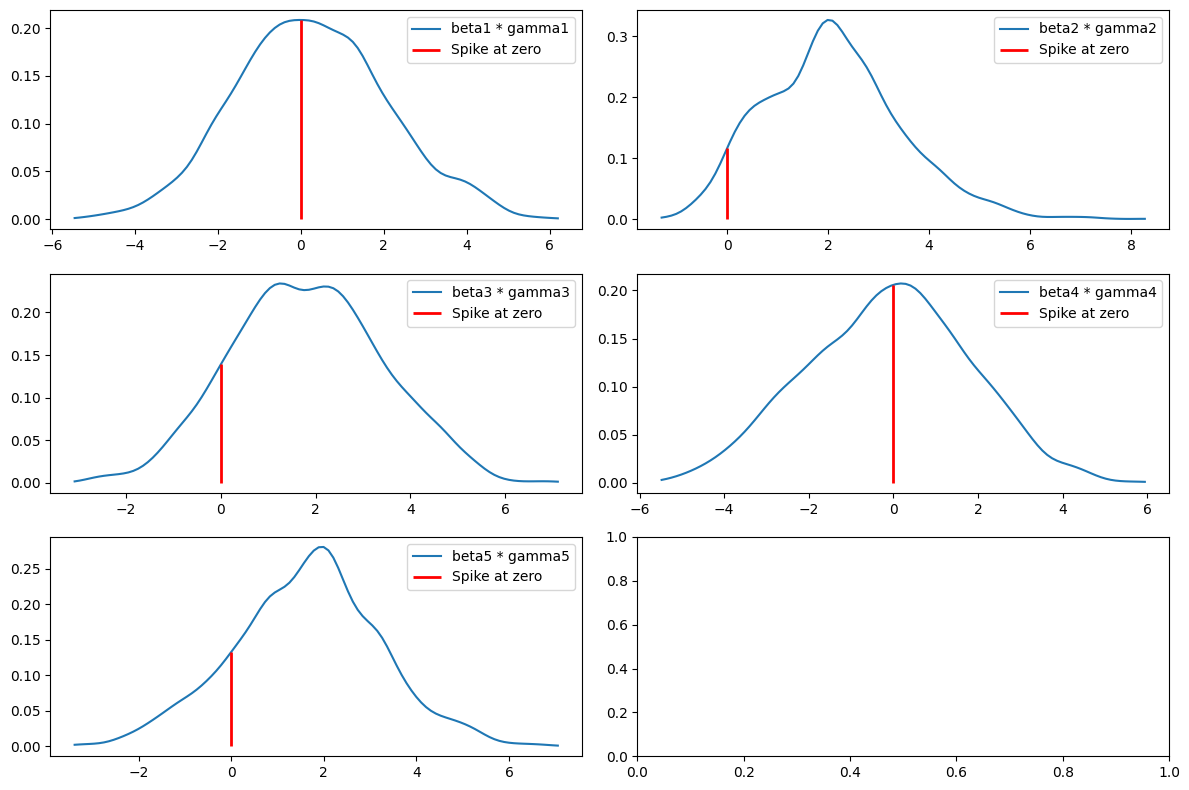

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.special import expit

# Assuming Beta_samples and Gamma_samples are NumPy arrays of shape (samples, features)
BG = Beta_samples * Gamma_samples

# Plot the posterior densities for beta_j * gamma_j
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for i in range(BG.shape[1]):
    ax = axes[i // 2, i % 2]
    # Handle the case where BG[:, i] might have all zeros
    data_nonzero = BG[:, i][BG[:, i] != 0]
    if len(data_nonzero) > 0:
        density = gaussian_kde(data_nonzero)
        x_grid = np.linspace(data_nonzero.min(), data_nonzero.max(), 100)
        ax.plot(x_grid, density(x_grid), label=f'beta{i+1} * gamma{i+1}')
        # Add a spike at zero if there are zeros
        if len(data_nonzero) < len(BG[:, i]):
            ax.vlines(0, 0, density(0), color='r', linewidth=2, label='Spike at zero')
    else:
        ax.vlines(0, 0, 1, color='r', linewidth=2, label='Spike at zero')  # Only a spike at zero
    ax.legend()
plt.tight_layout()

# Calculate posterior means for beta_j * gamma_j and the probability of gamma_j = 1
posterior_means_BG = np.mean(BG, axis=0)
prob_gamma = np.mean(Gamma_samples, axis=0)

# Combine the results into a structured array for display
results = np.vstack((posterior_means_BG, prob_gamma)).T
result_df = pd.DataFrame(results, columns=['Posterior Mean', 'Pr(gamma_j = 1|x,y)'], index=[f'beta{j+1} * gamma{j+1}' for j in range(BG.shape[1])])

# Display the results
print(result_df)

# Compute and print Pr(y_i = 1|x_i) for all samples
pi = expit(Beta0_samples + np.dot(X, BG.T))
print("Pr(y_i = 1|x_i) for all samples:")
print(pi)

# Problem 4: Exercise 11.4

In [2]:
# String data
data = """county    metstandard    percentms
Adams        0             43.8
Adams        1             33.3
Adams        1             41.7
Asotin       0             50.0
Asotin       0             69.8
Asotin       1             72.2
Benton       0             62.5
Benton       1             65.8
Benton       1             74.0
Benton       0             55.6
Benton       0             66.7
Benton       0             66.7
Benton       1             68.2
Benton       1             62.7
Chelan       0             70.0
Chelan       0             62.5
Chelan       1             65.4
Chelan       0             62.1
Chelan       0             54.5
Chelan       0             50.0
Chelan       0             57.4
Clallam      1             66.2
Clallam      0             63.2
Clallam      0             77.8
Clallam      0             48.1
Clallam      0             28.1
Clallam      1             42.9
Clallam      0             46.7
Clark        1             77.5
Clark        0             58.1
Clark        0             68.8
Clark        1             71.9
Clark        0             64.7
Clark        1             60.0
Clark        1             73.9
Clark        0            100.0
Clark        1             62.0
Clark        1             66.4
Clark        1             71.9
Clark        0             60.5
Clark        0             54.8
Clark        0             60.7
Clark        1             56.7
Clark        0             68.4
Clark        1             71.4
Columbia     1             43.5
Cowlitz      0             72.2
Cowlitz      1             69.2
Cowlitz      0             89.5
Cowlitz      0             67.7
Cowlitz      1             66.7
Cowlitz      0             50.0
Cowlitz      1             70.6
Cowlitz      0             65.9
Douglas      0             50.0
Douglas      0             80.0
Douglas      0             50.0
Ferry        0             55.0
Ferry        0             72.7
Ferry        0             66.7
Franklin     0             64.3
Franklin     0             53.3
Franklin     1             65.7
Franklin     0             53.8
Garfield     0             73.3
Grant        0             57.6
Grant        0             56.4
Grant        0             76.0
Grant        1             62.5
Grant        0             31.6
Grant        0             39.1
Grant        0             77.8
Grant        1             56.1
Grant        0             77.8
Grant        0             57.9
Grays_Harbor 0             51.7
Grays_Harbor 0             43.8
Grays_Harbor 0             53.8
Grays_Harbor 0             31.8
Grays_Harbor 1             67.6
Grays_Harbor 0             75.6
Grays_Harbor 0             42.9
Grays_Harbor 1             68.0
Grays_Harbor 0             68.8
Island       0             60.5
Island       1             73.1
Island       1             61.0
Jefferson    1             45.5
Jefferson    1             65.4
Jefferson    1             53.1
King         1             75.0
King         0             59.7
King         1             65.1
King         0             56.7
King         1             65.4
King         1             60.6
King         0             82.9
King         0             62.2
King         1             67.7
King         0             65.4
King         1             70.4
King         1             57.1
King         0             65.8
King         1             76.9
King         0             58.0
King         1             48.3
King         1             53.4
King         0             50.0
King         1             62.0
King         1             79.1
King         0             48.5
King         0             66.4
King         0             51.7
King         0             68.4
King         1             64.7
King         0             38.5
King         0             50.9
King         0             45.7
King         0             54.2
King         1             61.3
King         1             52.2
King         1             62.0
King         1             57.7
King         0             61.0
King         1             50.0
King         0             66.7
King         0             59.4
King         1             58.8
King         1             69.7
King         0             50.0
King         1             61.5
King         0             77.8
King         1             59.0
King         1             57.6
King         1             61.7
King         1             71.8
King         1             69.6
King         1             63.2
King         0             37.5
King         1             50.0
King         1             57.9
King         1             48.5
King         0             20.0
King         1             61.3
King         0             52.7
King         1             59.4
King         1             62.7
King         1             57.3
King         1             67.4
King         1             69.9
King         1             64.0
Kitsap       0             56.1
Kitsap       1             79.5
Kitsap       0             71.4
Kitsap       0             62.5
Kitsap       1             61.0
Kitsap       1             56.9
Kitsap       1             65.7
Kitsap       1             65.6
Kitsap       0             66.4
Kittitas     1             62.0
Kittitas     0             61.1
Kittitas     0             50.0
Klickitat    1             66.7
Klickitat    0             73.9
Klickitat    1             56.5
Klickitat    0             33.3
Lewis        1             70.8
Lewis        0             69.6
Lewis        0             47.1
Lewis        0             80.0
Lewis        0             75.0
Lewis        0             76.2
Lewis        0             63.6
Lewis        1             71.4
Lewis        1             83.0
Lewis        0             45.8
Lewis        0             54.1
Lincoln      0             57.9
Lincoln      0             62.5
Lincoln      1             84.2
Lincoln      0             69.2
Lincoln      0             65.0
Mason        0             45.2
Mason        0             50.0
Mason        1             72.7
Mason        0             50.0
Mason        1             68.2
Okanogan     0             51.4
Okanogan     0             51.9
Okanogan     0             68.4
Okanogan     1             61.5
Okanogan     1             70.0
Okanogan     0             57.7
Okanogan     0             59.1
Pacific      0             27.3
Pacific      1             68.4
Pacific      0             63.6
Pacific      0             56.5
Pend_Oreille 1             61.8
Pend_Oreille 0             58.3
Pend_Oreille 1             70.6
Pierce       0             50.0
Pierce       0             58.3
Pierce       1             62.6
Pierce       0             43.8
Pierce       0             59.1
Pierce       1             51.2
Pierce       0             43.0
Pierce       0             55.1
Pierce       0             40.4
Pierce       0             58.0
Pierce       0             50.0
Pierce       1             63.5
Pierce       1             56.4
Pierce       0             52.8
Pierce       0             61.3
Pierce       0             51.4
Pierce       0             58.3
Pierce       1             70.0
Pierce       1             73.8
Pierce       0             44.2
Pierce       0             66.7
Pierce       0             57.0
Pierce       0             65.3
Pierce       0             66.7
Pierce       0             72.2
Pierce       1             60.4
San_Juan     1             36.8
San_Juan     1             70.0
San_Juan     1             77.8
Skagit       0             50.0
Skagit       1             67.7
Skagit       0             68.8
Skagit       1             59.7
Skagit       1             55.8
Skagit       1             71.4
Skagit       0             65.5
Skamania     0             72.7
Snohomish    0             50.6
Snohomish    0             54.5
Snohomish    0             58.8
Snohomish    1             65.9
Snohomish    1             62.9
Snohomish    0             71.4
Snohomish    0             54.7
Snohomish    1             54.7
Snohomish    1             69.6
Snohomish    1             74.0
Snohomish    1             63.4
Snohomish    1             69.0
Snohomish    0             66.7
Snohomish    0             33.3
Snohomish    1             55.7
Snohomish    0             63.6
Snohomish    0             80.0
Snohomish    0             53.2
Snohomish    0             58.3
Snohomish    0             63.6
Snohomish    0            100.0
Snohomish    0             70.5
Snohomish    1             62.5
Snohomish    1             61.1
Snohomish    0             43.3
Snohomish    1             63.2
Snohomish    0             63.2
Snohomish    1             82.0
Spokane      0             67.8
Spokane      1             65.0
Spokane      0             68.7
Spokane      1             67.4
Spokane      0             56.3
Spokane      1             68.1
Spokane      1             59.5
Spokane      0             61.1
Spokane      0             85.7
Spokane      0             50.0
Spokane      1             77.6
Spokane      1             62.5
Spokane      1             64.4
Spokane      1             69.6
Spokane      0             61.5
Spokane      1             76.9
Spokane      0            100.0
Spokane      1             74.2
Spokane      1             73.6
Spokane      0             73.3
Spokane      0             92.3
Spokane      0             57.1
Spokane      0             71.9
Spokane      1             65.7
Stevens      1             73.1
Stevens      0             65.2
Stevens      1             66.7
Stevens      1             65.0
Stevens      0             40.0
Stevens      1             50.0
Stevens      0             70.6
Thurston     1             58.2
Thurston     0             55.8
Thurston     0             71.4
Thurston     0             75.0
Thurston     1             53.6
Thurston     1             71.9
Thurston     1             60.3
Thurston     0             57.1
Thurston     1             71.0
Thurston     1             66.7
Thurston     1             65.7
Thurston     1             64.5
Thurston     0             51.9
Wahkiakum    0             69.2
Walla_Walla  0             85.7
Walla_Walla  1             76.7
Walla_Walla  0            100.0
Walla_Walla  0             54.2
Walla_Walla  0             56.5
Walla_Walla  0             50.0
Walla_Walla  0             56.5
Whatcom      0             28.6
Whatcom      1             70.7
Whatcom      1             68.4
Whatcom      1             76.6
Whatcom      1             75.3
Whatcom      1             65.7
Whatcom      1             60.0
Whatcom      1             46.4
Whatcom      0             52.6
Whatcom      1             61.5
Whitman      1             45.5
Whitman      1             55.6
Whitman      1             68.9
Whitman      1             82.6
Whitman      1             72.7
Whitman      1             81.3
Whitman      0             90.0
Whitman      1             58.3
Whitman      1             85.7
Yakima       0             44.8
Yakima       0             54.1
Yakima       0             52.2
Yakima       0             55.6
Yakima       0             68.3
Yakima       0             90.0
Yakima       0             50.0
Yakima       0             50.0
Yakima       0             50.0
Yakima       0             71.4
Yakima       0             48.6
Yakima       0             55.6
Yakima       0             53.7
Yakima       0             59.1
Yakima       0             40.9
Yakima       0             65.9
Yakima       0             36.6
Yakima       0             25.0
Yakima       1             57.1
Yakima       0             26.9
Clark        1             73.3
Grays_Harbor 0             35.7
Lewis        0            100.0
Clark        1             71.4
Grant        0             53.3
Spokane      0             75.0
Kitsap       1             71.4
King         0             68.8
Snohomish    0             54.5
King         1             77.4
Snohomish    1             41.7
Grant        0             60.0
Spokane      0             84.6
Spokane      0            100.0
King         1             56.1
Pierce       0             59.2"""

# Read string data into a pandas DataFrame
dat = pd.read_csv(StringIO(data), delim_whitespace=True)

# Print the DataFrame
dat.head()

,county,metstandard,percentms
0,Adams,0,43.8
1,Adams,1,33.3
2,Adams,1,41.7
3,Asotin,0,50.0
4,Asotin,0,69.8


## b)

In [3]:
# First, calculate the number of schools per county
schools_per_county = dat['county'].value_counts()

# Filter counties with 10 or more schools
counties = schools_per_county[schools_per_county >= 10].index

Beta_ml = []
filtered_counties = []

for c in counties:
    dat_c = dat[dat['county'] == c]
    yj = dat_c['metstandard']
    xj = sm.add_constant(dat_c['percentms'])  # Add constant for intercept
    try:
        model = sm.Logit(yj, xj).fit(disp=0)  # Fit model without printing output
        Beta_ml.append(model.params.values)
        filtered_counties.append(c)  # Keep track of counties included in analysis
    except np.linalg.LinAlgError:  # Catch cases where the model can't be fitted
        continue  # Skip this county if the model can't be fitted

Beta_ml = np.array(Beta_ml)

In [4]:
# Assuming Beta_ml is the array of MLEs you've obtained
theta_hat = Beta_ml.mean(axis=0)  # Mean of beta estimates across counties
Sigma_hat = np.cov(Beta_ml.T)  # Covariance matrix of beta estimates

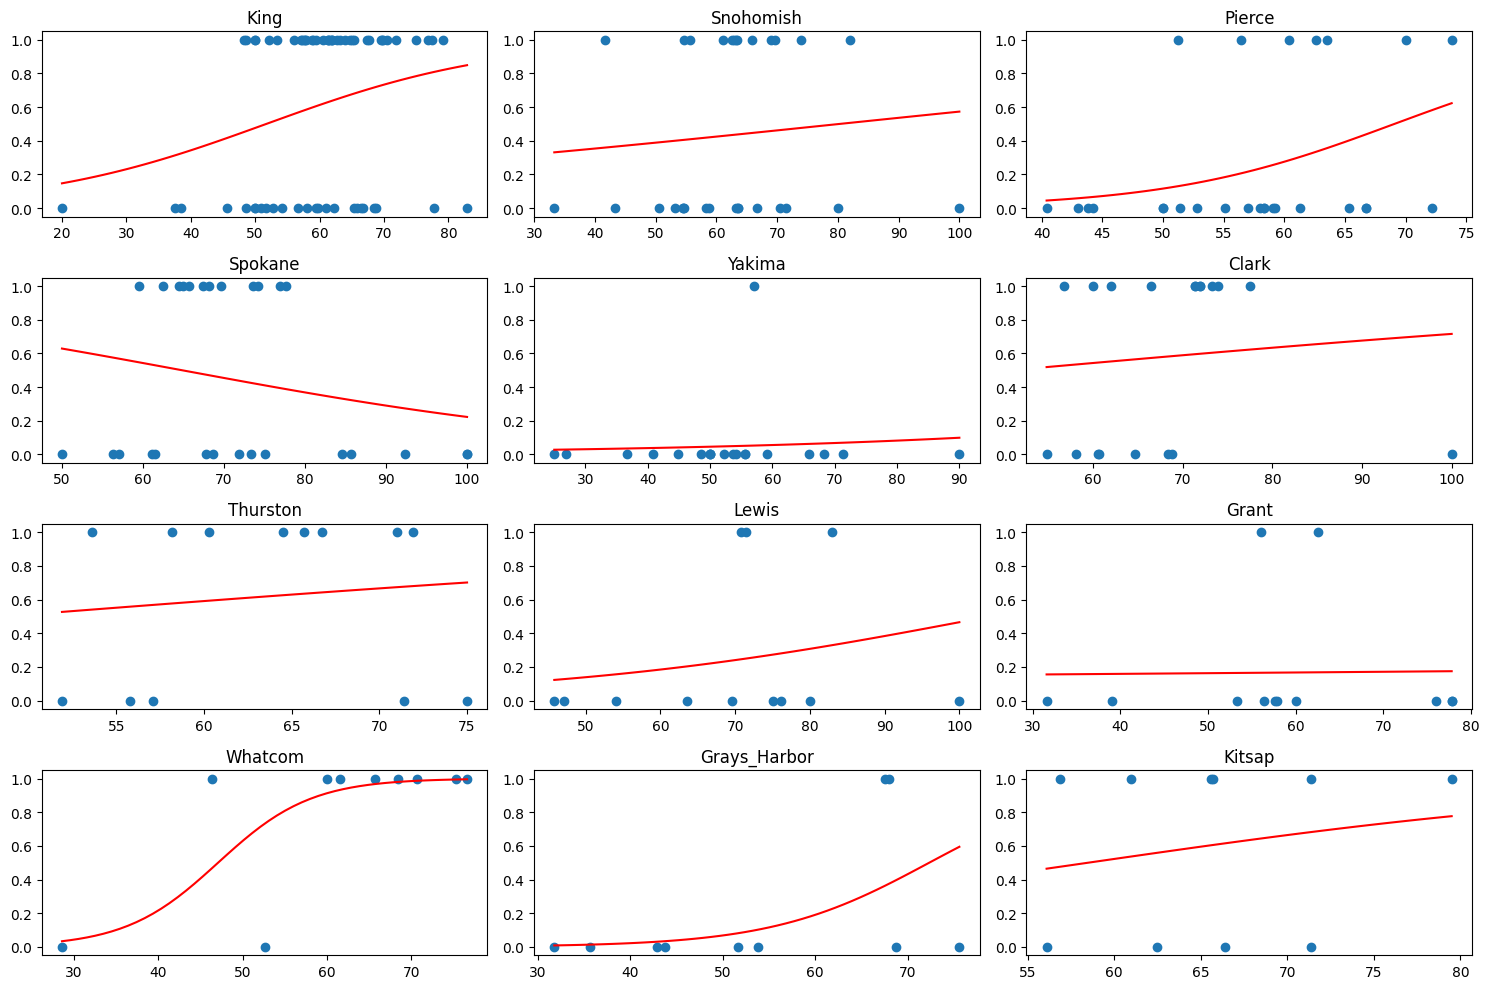

In [5]:
# Plotting
fig, axes = plt.subplots(nrows=int(np.ceil(len(filtered_counties)/3)), ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, c in enumerate(filtered_counties):
    ax = axes[i]
    dat_c = dat[dat['county'] == c]
    xj = dat_c['percentms']
    yj = dat_c['metstandard']
    beta = Beta_ml[i]

    x = np.linspace(xj.min(), xj.max(), 50)
    ax.plot(xj, yj, 'o')
    ax.plot(x, 1 / (1 + np.exp(-(beta[0] + beta[1] * x))), 'r-')  # Logistic function
    ax.set_title(c)

plt.tight_layout()
plt.show()


## c)

In [6]:
def sample_theta(Beta, Sigma, mu0, Lambda0):
    n_group = Beta.shape[1]
    iSigma = inv(Sigma)
    iLambda0 = inv(Lambda0)

    mBeta = Beta.mean(axis=1)
    Lambdam = inv(iLambda0 + n_group * iSigma)
    mum = Lambdam @ (iLambda0 @ mu0[:, None] + n_group * iSigma @ mBeta[:, None])

    return multivariate_normal.rvs(mean=mum.flatten(), cov=Lambdam)

def sample_Sigma(Beta, theta, eta0, S0):
    g = Beta.shape[1]
    Sn = S0 + ((Beta - theta[:, None]) @ (Beta - theta[:, None]).T)
    return inv(wishart.rvs(df=eta0 + g, scale=inv(Sn)))

def logistic_regression_log_prior(beta, theta, Sigma):
    return multivariate_normal.logpdf(beta, mean=theta, cov=Sigma)

def logistic_regression_log_likelihood(beta, y, X):
    eta = X @ beta
    return np.sum(y * eta - np.log(1 + np.exp(eta)))

def sample_Beta(y, X, groups, theta, Sigma, Beta, adj_prop):
    Beta_new = np.empty(Beta.shape)
    Acs = []

    ugroups = np.unique(groups)
    for g in ugroups:
        idx = groups == g
        Xg, yg = X[idx], y[idx]
        betag = Beta[:, g:g+1].flatten()

        # Proposal step
        beta_p = multivariate_normal.rvs(mean=betag, cov=adj_prop * Sigma)

        # Log likelihood ratio
        lhr = (logistic_regression_log_likelihood(beta_p, yg, Xg) -
               logistic_regression_log_likelihood(betag, yg, Xg) +
               logistic_regression_log_prior(beta_p, theta, Sigma) -
               logistic_regression_log_prior(betag, theta, Sigma))

        # Acceptance step
        if np.log(np.random.rand()) < lhr:
            Beta_new[:, g] = beta_p
            Acs.append(1)
        else:
            Beta_new[:, g] = betag
            Acs.append(0)

    return Beta_new, np.mean(Acs)


In [7]:
# Assuming `dat` is your DataFrame
schools_per_county = dat['county'].value_counts()
large_counties = schools_per_county[schools_per_county >= 10].index
filtered_data = dat[dat['county'].isin(large_counties)]

In [8]:
# Prepare the variables for analysis
y = filtered_data['metstandard'].values
X = np.column_stack((np.ones(len(filtered_data)), filtered_data['percentms'].values))
groups = pd.factorize(filtered_data['county'])[0]  # Numeric encoding of county groups

# Calculate theta_hat and Sigma_hat, assuming Beta_ml is calculated as shown previously
# theta_hat and Sigma_hat calculation should be based on the previous steps

In [9]:
# Assuming you have 2 predictors (intercept and percentms)
p = 2
n_group = len(np.unique(groups))

# Initial parameters
mu0 = theta_hat  # Use theta_hat as the initial mean for theta
Lambda0 = Sigma_hat  # Use Sigma_hat as the initial covariance matrix for theta
eta0 = 4  # Degrees of freedom for the Wishart distribution
S0 = Sigma_hat  # Scale matrix for the Wishart distribution
adj_prop = 1.2  # Adjustment parameter for the proposal distribution


In [10]:
theta_hat, Sigma_hat

(array([-3.46274672,  0.05070387]),
 array([[ 1.07558215e+01, -1.79360977e-01],
        [-1.79360977e-01,  3.48979959e-03]]))

In [11]:
n_iter = 10000  # Define the number of iterations for the MCMC process

# Initialize arrays to store samples
theta_samples = np.zeros((n_iter, p))
Sigma_samples = np.zeros((n_iter, p, p))
Beta_samples = np.zeros((n_iter, p, n_group))

# Initial values for theta and Sigma
theta = mu0
Sigma = S0
Beta = np.tile(mu0, (n_group, 1)).T  # Initialize Beta for each group with mu0

# MCMC sampling loop (simplified version)
for i in range(n_iter):
    theta = sample_theta(Beta, Sigma, mu0, Lambda0)
    Sigma = sample_Sigma(Beta, theta, eta0, S0)
    Beta, _ = sample_Beta(y, X, groups, theta, Sigma, Beta, adj_prop)

    # Store the samples
    theta_samples[i] = theta
    Sigma_samples[i] = Sigma
    Beta_samples[i] = Beta

# At this point, theta_samples, Sigma_samples, and Beta_samples contain your posterior samples


## d)

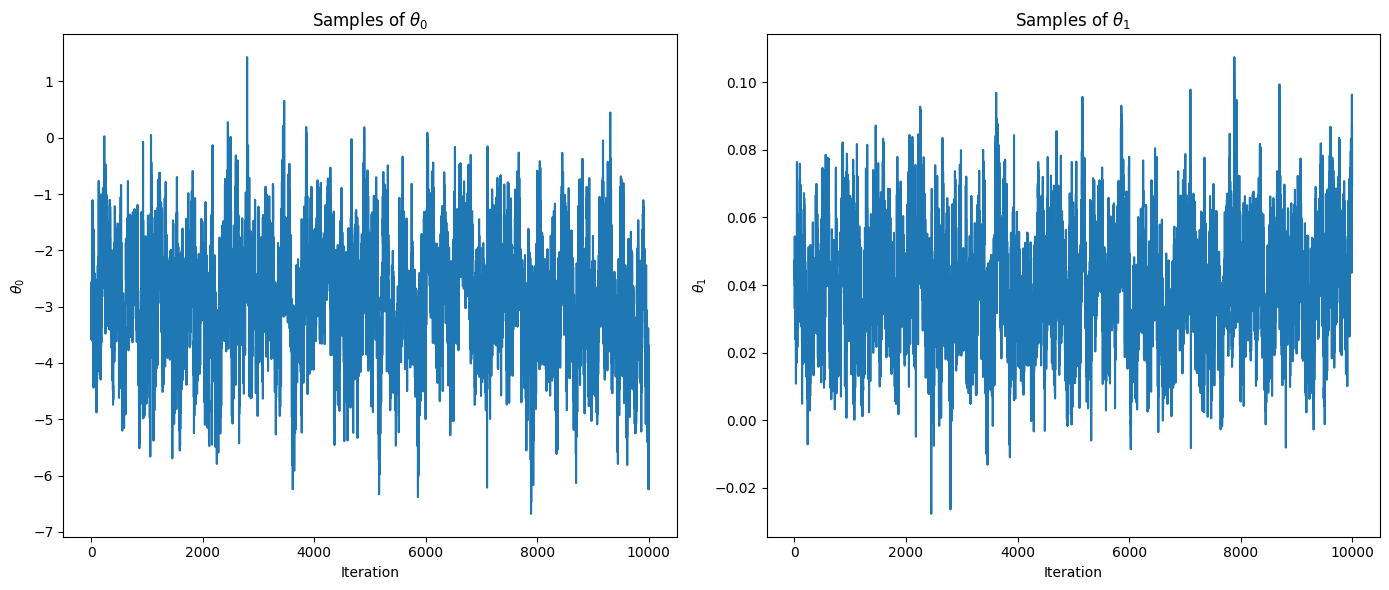

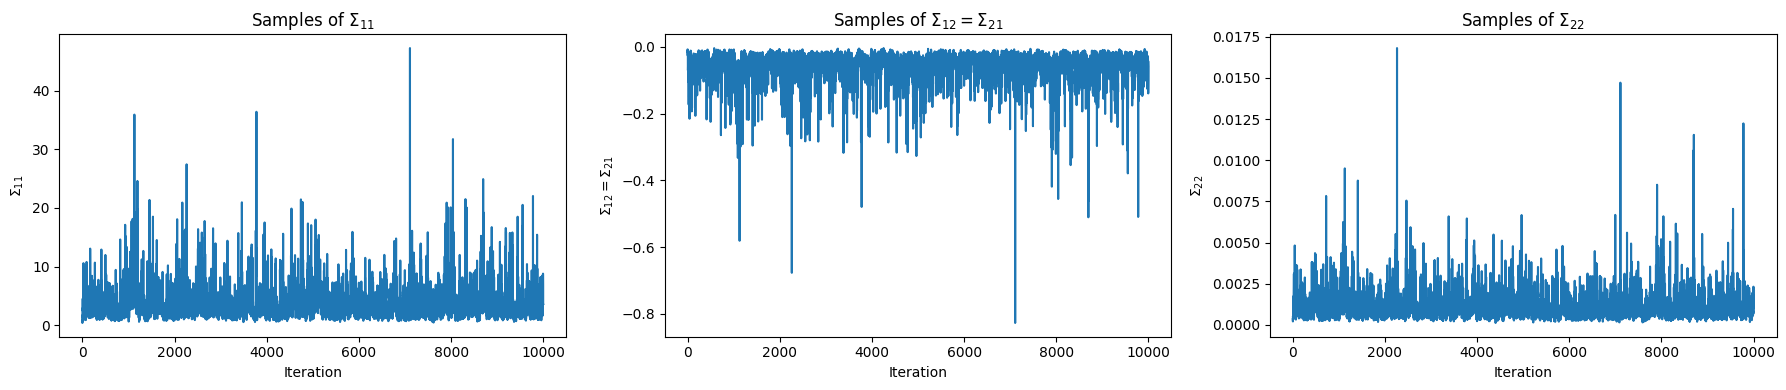

In [12]:
n_iter = len(theta_samples)  # Number of MCMC iterations

# Plotting theta samples
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(n_iter), theta_samples[:, 0], label=r'$\theta_0$')
plt.xlabel('Iteration')
plt.ylabel(r'$\theta_0$')
plt.title(r'Samples of $\theta_0$')

plt.subplot(1, 2, 2)
plt.plot(range(n_iter), theta_samples[:, 1], label=r'$\theta_1$')
plt.xlabel('Iteration')
plt.ylabel(r'$\theta_1$')
plt.title(r'Samples of $\theta_1$')

plt.tight_layout()
plt.show()

# Plotting Sigma samples
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(range(n_iter), [Sigma_samples[i, 0, 0] for i in range(n_iter)], label=r'$\Sigma_{11}$')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\Sigma_{11}$')
ax[0].set_title(r'Samples of $\Sigma_{11}$')

ax[1].plot(range(n_iter), [Sigma_samples[i, 0, 1] for i in range(n_iter)], label=r'$\Sigma_{12}=\Sigma_{21}$')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'$\Sigma_{12}=\Sigma_{21}$')
ax[1].set_title(r'Samples of $\Sigma_{12}=\Sigma_{21}$')

ax[2].plot(range(n_iter), [Sigma_samples[i, 1, 1] for i in range(n_iter)], label=r'$\Sigma_{22}$')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel(r'$\Sigma_{22}$')
ax[2].set_title(r'Samples of $\Sigma_{22}$')

plt.tight_layout()
plt.show()

## e)

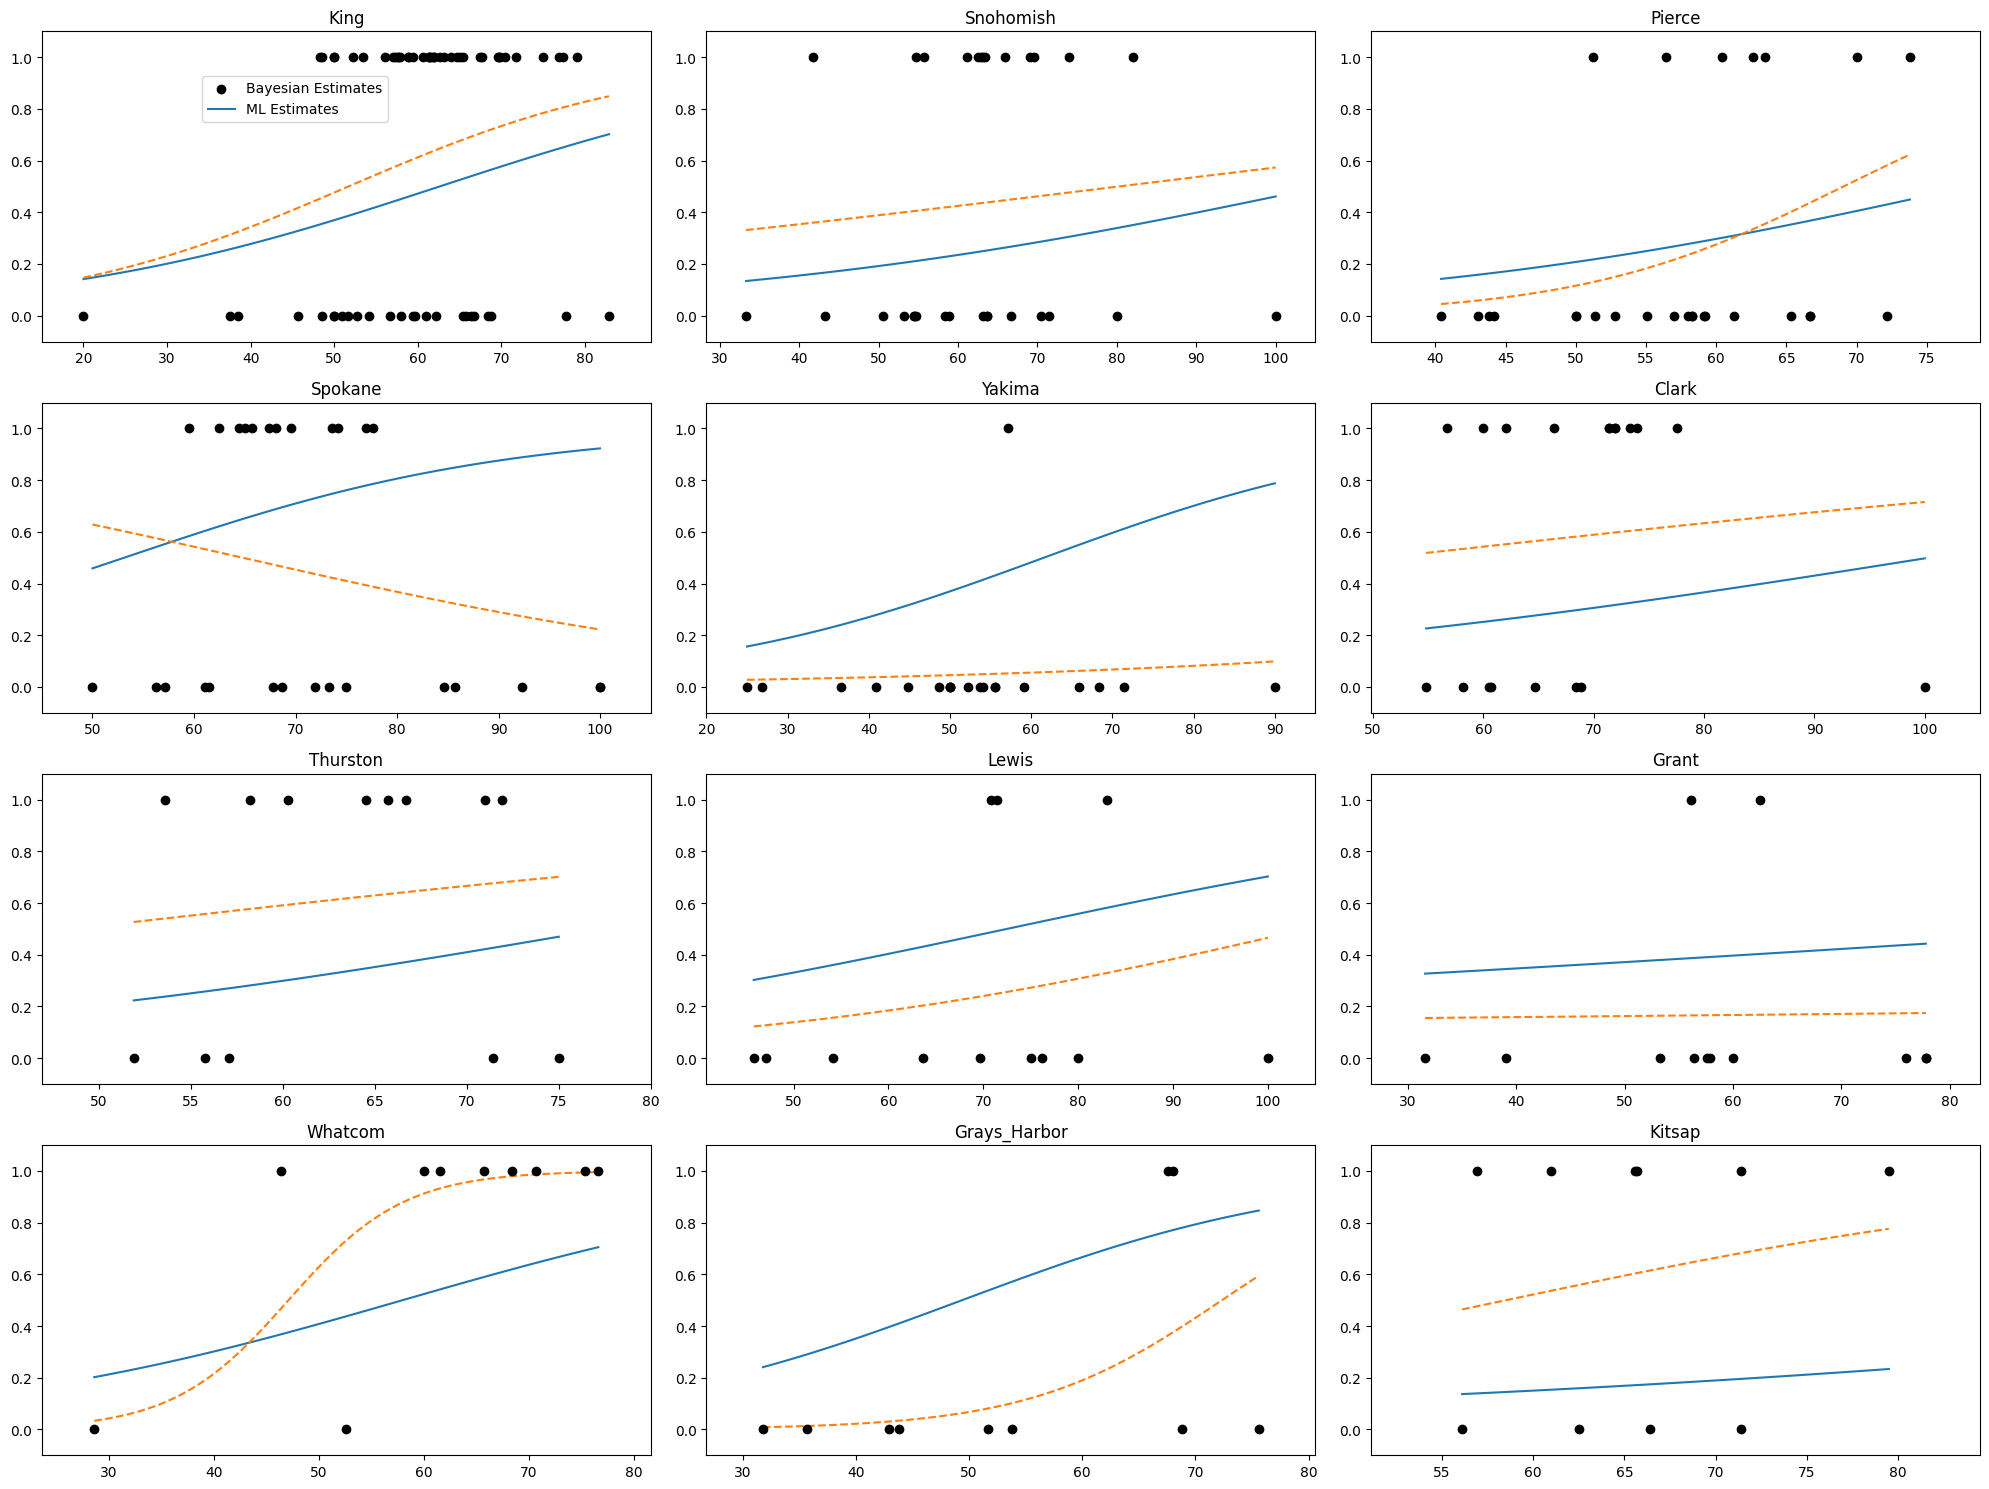

In [14]:
Beta_bayes = Beta_samples.mean(axis=0)

# Define your plotting function for logistic regression
def plot_logistic_regression(ax, x, beta, label, style):
    x_values = np.linspace(min(x), max(x), 100)
    y_values = expit(beta[0] + beta[1] * x_values)
    ax.plot(x_values, y_values, label=label, linestyle=style)

# Assuming dat is your filtered DataFrame, Beta_ml is defined, and Beta_bayes is calculated
# Assuming filtered_counties is the list of counties with 10 or more schools

# Setup the plot
fig, axes = plt.subplots(nrows=int(np.ceil(len(filtered_counties)/3)), ncols=3, figsize=(20, 15), squeeze=False)
axes = axes.flatten()

# Plot each county
for i, county in enumerate(filtered_counties):
    county_data = dat[dat['county'] == county]
    xj = county_data['percentms'].values
    yj = county_data['metstandard'].values
    ax = axes[i]

    # Plot the data points
    ax.scatter(xj, yj, color='black', zorder=5)

    # Plot Bayesian regression line
    plot_logistic_regression(ax, xj, Beta_bayes[:, i], 'Bayesian Estimates', '-')

    # Plot ML regression line
    plot_logistic_regression(ax, xj, Beta_ml[i], 'ML Estimates', '--')

    # Setting plot titles and limits
    ax.set_title(county)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(min(xj)-5, max(xj)+5)

# Adjust layout and add a legend
plt.tight_layout()
fig.legend(['Bayesian Estimates', 'ML Estimates'], loc='upper left', bbox_to_anchor=(0.1, 0.95))
plt.show()

## f)

In [21]:
# Drawing samples from the prior for theta
theta_prior = multivariate_normal.rvs(mean=theta_hat, cov=Sigma_hat, size=10000)

# Drawing samples from the prior for Sigma
Sigma_prior_samples = np.array([wishart.rvs(df=4, scale=Sigma_hat) for _ in range(10000)])
# We take the inverse because the Wishart distribution is for the precision matrix (inverse of the covariance matrix)
Sigma_prior = np.linalg.inv(Sigma_prior_samples)

In [27]:
Sigma_samples.shape

(10000, 2, 2)

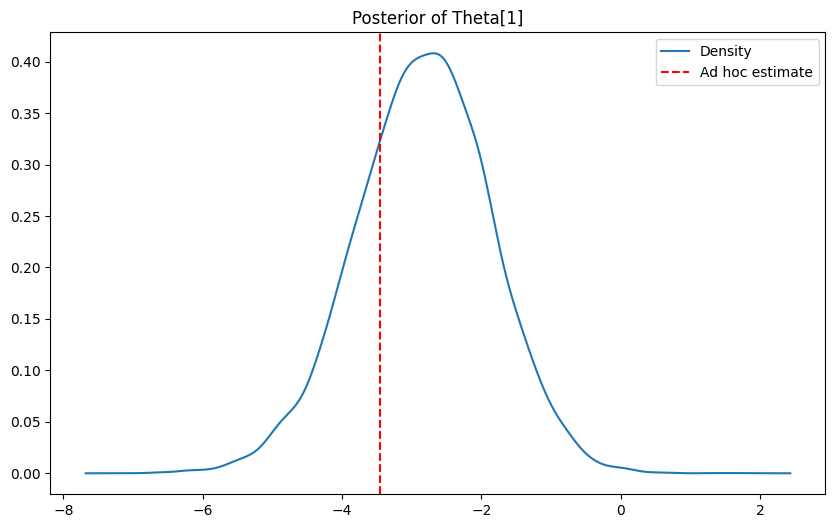

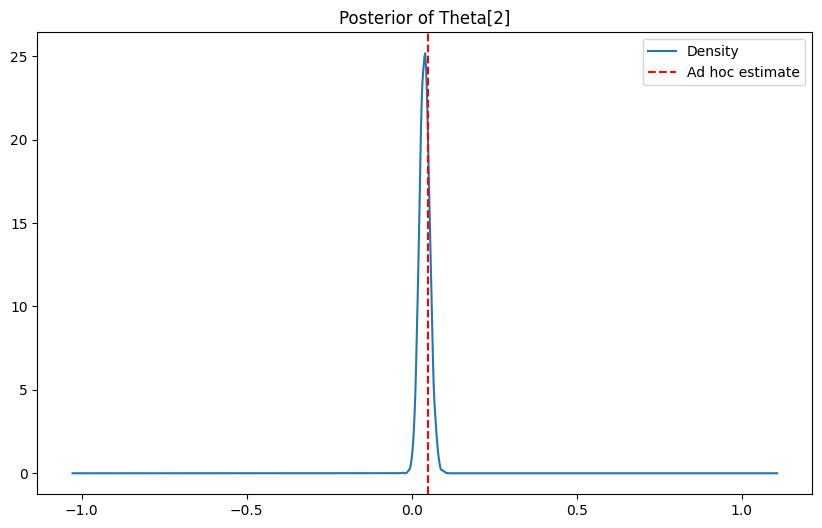

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Function to plot a single density
def plot_density(data, title, ad_hoc_estimate=None):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data) - 1, max(data) + 1, 1000)
    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, kde(x_grid), label='Density')
    if ad_hoc_estimate is not None:
        plt.axvline(ad_hoc_estimate, color='red', linestyle='--', label='Ad hoc estimate')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the densities for theta
for i in range(2):
    plot_density(theta_samples[:, i], f'Posterior of Theta[{i+1}]', theta_hat[i])


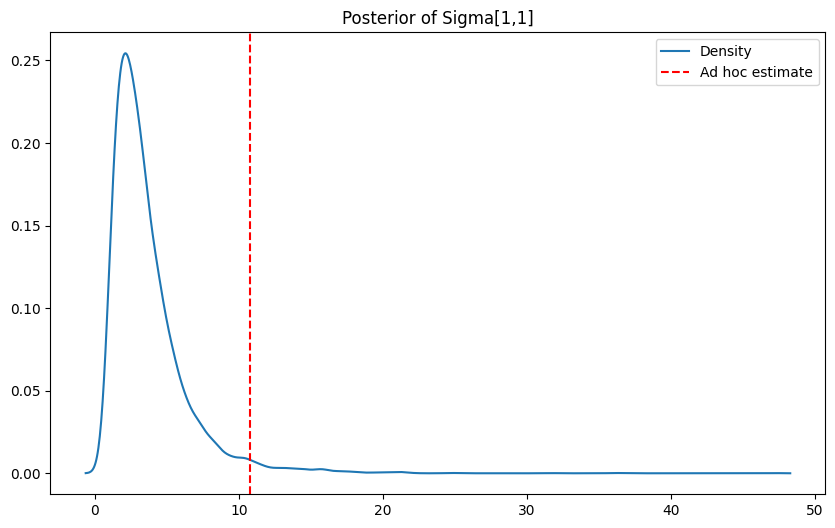

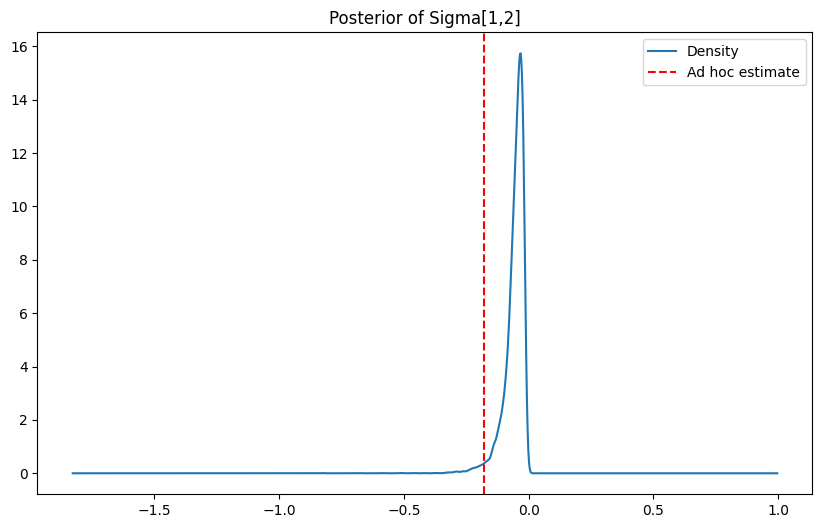

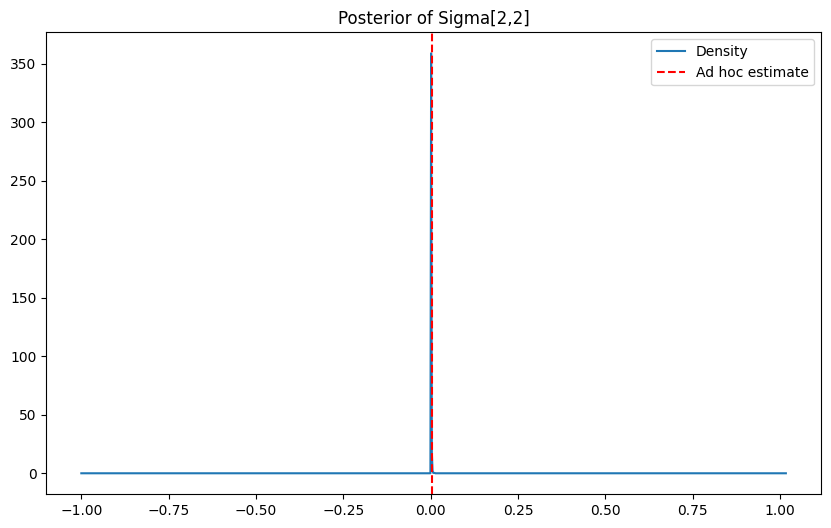

In [30]:
# Assuming Sigma_prior is correctly calculated and has the shape (10000, 3) corresponding to the unique elements
for i, index in enumerate([(0, 0), (0, 1), (1, 1)]):
    plot_density(Sigma_samples[:, index[0], index[1]].flatten(), f'Posterior of Sigma[{index[0]+1},{index[1]+1}]', Sigma_hat[index])
